# BDT implementation for the ATLAS search 2101.12527 (SRD Signal Region)

Most information can be found in this PhD thesis about the BDT implementation of ATLAS: https://inspirehep.net/files/1e0c3c7a061e00a13ecab29a73d7ed62, on the PDF page 125. The other helpful thing is the ATLAS analysis itself: https://arxiv.org/pdf/2101.12527 . 
Additional plots etc are available here: https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/SUSY-2018-34/

Here are the variables that the BDT (that should be **AdaBoost**) was trained on:

<img src="/home/armankorajac/MET_and_b_project/Recast_ATLAS_2101_SRD/bdt-2.png" alt="The cuts" />

Here: 
\begin{equation} 
H_T^{\rm ratio} = p_T(j_1)/H_T \nonumber 
\end{equation} 
where $H_T$ is the scalar sum of the transverse momentum of the jets. $H_T$ is accessible through the ROOT file.\
Furthermore, $\delta^-$ and $\delta^+$ are defined as:
\begin{equation}
\delta^- = \Delta \phi (j, p_T^{\rm miss}) - \Delta \phi_{b \bar{b}} \nonumber
\end{equation}

\begin{equation}
\delta^+ = |\Delta \phi (j, p_T^{\rm miss}) + \Delta \phi_{b \bar{b}} - \pi | \nonumber
\end{equation}

and $\Delta \phi_{b \bar{b}}$ is the azimuthal separation between the two most probably tagged $b$-jets. 

For the BDTs itself, it seems a couple of them were trained (for each BKG separately), and these are the relevant parameters:

<img src="/home/armankorajac/MET_and_b_project/Recast_ATLAS_2101_SRD/bdt-1.png" alt="The cuts" />

These are the cuts in the SRD region, implemented on the BDT scores (left column is for **SRD-low** and the right one for **SRD-high**)

In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


from pygram11 import histogram


The style that we use for the plots:

In [2]:
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

plt.rcParams['figure.dpi'] = 100

Functions for plotting the training and testing data (although we have one in the loop):

In [49]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bckg_str):
    # function to compare the classifier decision function for train and test
    # clf: classifier
    # X_train: training data
    # y_train: training labels
    # X_test: test data
    # y_test: test labels
    # bckg_str: string to identify the background
    
    binwidth = 0.075 # bin width for histogram
    bin_edge = - 2.0 # start the bin edge counter here
    bin_edge_max = 2.0 # bin width for histogram

    if bckg_str == 'w':
        binwidth = 0.075
        bin_edge = -2 # start the bin edge counter here
        bin_edge_max = 2 # bin width for histogram


    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.decision_function(X[y <= 0.5]).ravel() # background
        #d1_normalized = 2 * (d1 - d1.min()) / (d1.max() - d1.min()) - 1 # so it's between -1 and +1
        
        d2 = clf.decision_function(X[y > 0.5]).ravel() # signal
        #d2_normalized = 2 * (d2 - d2.min()) / (d2.max() - d2.min()) - 1 # so it's between -1 and +1

        decisions += [d1, d2] # add to list of classifier decision # CHANGE THIS IF WE NEED TO NORMALISE
    
    bin_edges = [] # list to hold bin edges
    while bin_edge <= bin_edge_max: # up to highest score
        bin_edges.append(bin_edge)
        bin_edge += binwidth # increment
        
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='red', label='B (train)', # Background (train)
            alpha=0.5) # half transparency
    plt.hist(decisions[1], # signal in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='S (train)', # Signal (train)
            alpha=0.5) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='B (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # signal test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background

    area_signal = np.sum(hist_signal * binwidth)
    area_background = np.sum(hist_background * binwidth)

    print(f"Area under signal histogram: {area_signal:.4f}")
    print(f"Area under background histogram: {area_background:.4f}")
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='blue', label='S (test)' ) # Signal (test)
    
    plt.xlabel("BDT output") # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend

Define the azimuthal separation angle if you have the $p_T$ components:

In [4]:
def deltaphi(a,b):
    x = np.abs(np.arctan2(a[1], a[0])-np.arctan2(b[1], b[0]))
    if x > np.pi:
        return 2*np.pi - x
    else:
        return x

# Initialization:

Define the cuts:

In [5]:
metCutMin = 180.0
ptj1CutMin = 100.0 #for a b- and a non-b jet
ptj2CutMin = 50.0 
ptj3CutMin = 35.0
hTratioCutMin = 0.7 #the event has to have a LARGER hTratioCut than 0.7
nBjetMin = 2
delPhijMETMin = 0.4 #The last cut - for the angles - any jet needs to fulfill this requirement
etabMax = 2.5
pTmin = 35 # The minimum pT that jets have to have

#Don't forget no leptons in the event, and the number of jets either 2 or 3!

sMin = 0 #7 is for the real MET Significance. Let's raise this, because 7 is too low it seems for this fake MET significance. 9 gives a biit better results at least for tt! Put 11

#EDIT : We set the minimal sMin to 0, so all the events will pass w.r.t. a S cut. However, AT A LATER STAGE, place a meaningful (i.e. one that maximizes S/B) S cut!

Check if we are in the virtual environment: 

In [6]:
import sys
print(sys.executable)

/home/armankorajac/py3VirtEnv/bin/python


Set the luminosity of the experiment (**has to be in inverse picobarn!**):

In [7]:
luminosity = 139.0*1000

Very important: Implement also the K-factor, as done in the ATLAS analysis. The result should be presented in this DM + b-bbar paper:\
https://arxiv.org/pdf/1811.08002.pdf

In [8]:
fivetofourFS = 2.18 #This is the value of (sigma5FS)_NLO/(sigma4FS)_NLO from Fig. 1 right of the DM + bbbar paper: https://arxiv.org/pdf/1811.08002. Watch out about the log scale when you digitize the plot!
kfactor = 1.07 #Note that we have sigma4FS_LO generated. Correct the 4FS LO to 4FS NLO!

The function for extracting the events - the cut-and-count analysis:

In [9]:
def extract_events_SRd(input_root_file_dest):

    #tree = uproot.open({input_root_file_dest: "CollectionTree"})

    rootfile = uproot.open(input_root_file_dest)

    #Define the relevant ROOT trees

    treeMET = rootfile['Delphes']['MissingET']
    treeJet = rootfile['Delphes']['Jet']
    treeMuon = rootfile['Delphes']['Muon']
    treeElectron = rootfile['Delphes']['Electron']
    treeMuon = rootfile['Delphes']['Muon']
    treeEvent = rootfile['Delphes']['Event']
    treeWeight = rootfile['Delphes']['Weight']
    treescalarHT = rootfile['Delphes']['ScalarHT']

    #Define the branches

    branchesMET = treeMET.arrays()
    branchesJet = treeJet.arrays()
    #branchesMuon = treeMuon.arrays() - For some reason we cannot access all the arrays of this branch, but the PT, eta..we can. Check the rest of the code
    branchesElectron = treeElectron.arrays()
    branchesWeight = treeWeight.arrays()
    branchesEvent = treeEvent.arrays()
    branchesScalarHT = treescalarHT.arrays()

    #The array of the weights of events. 

    weightsofEvents = np.array(ak.flatten(branchesEvent['Event.Weight']).tolist())
    #the number of events:
    noOfEvsinFile = len(ak.flatten(branchesEvent['Event.Weight']).tolist())
    print("The number of events in this file is:", noOfEvsinFile)
    print("The sum of weights is: {}".format(np.sum(weightsofEvents)))
    print("The x-sec should be: {}".format(np.sum(weightsofEvents)/noOfEvsinFile))

    #Setting the cuts

    #MET cut:
    METhisto = np.array(ak.flatten(branchesMET['MissingET.MET'].tolist()))
    MET_mask = np.array([x > metCutMin for x in METhisto])


    #Electron and muon multiplicity cut:

    electron_pts = branchesElectron['Electron.PT'].tolist()

    electron_mask = np.array([len(electron_pts[i]) == 0 for i in range(len(electron_pts))])

    muon_pts = treeMuon['Muon.PT'].arrays()['Muon.PT'].tolist()

    muon_mask = np.array([len(muon_pts[i]) == 0 for i in range(len(muon_pts))])

    #pT cut of the jets, and their multiplicity. Take the jets that have only pT > 35 GeV - those are real, physical jets!

    pTjetnp = branchesJet['Jet.PT'][branchesJet['Jet.PT'] > pTmin].tolist() 

    # Now the pT masks for the first and the second jet

    pT_mask_total = np.array([(pTjetnp[i][0] > ptj1CutMin and pTjetnp[i][1] > ptj2CutMin) if (len(pTjetnp[i]) > 1 and len(pTjetnp[i]) < 4) else False for i in range(len(pTjetnp))])
 
    #Phi coordinates for the pTmiss vector
    pTmissPhiAngles =  np.array(branchesMET['MissingET.Phi'].tolist()).flatten()

    #Phi coordinates from the jets
    jetPhiAngles = branchesJet['Jet.Phi'][branchesJet['Jet.PT'] > pTmin].tolist()

    #Scalar HT requirement

    scalarHThisto = np.array(ak.flatten(branchesScalarHT['ScalarHT.HT'].tolist()))

    scalarHTratio_mask = np.array([(np.abs(pTjetnp[i][0])/np.abs(scalarHThisto[i])) > hTratioCutMin if (len(pTjetnp[i]) > 0) else False for i in range(len(scalarHThisto))])


    #The simplified MET Significance cut:
    #We use the following simplified definition of S:
    # S = MET/sqrt(HT)
    #Described in https://indico.in2p3.fr/event/13330/contributions/13788/attachments/11584/14278/JRJC_09-12-2016.pdf

    METsign_simpl = METhisto/np.sqrt(scalarHThisto)
    METsign_simpl_mask = np.array([x > sMin for x in METsign_simpl])

    #Angular requirement mask - the min angle between the first three jets and MET should be 0.4.
    #The counter i goes through events, j goes inside through the jets - taking only the first, second and third jet into account
    #So what do we do here:
        #First of all, there has to be at least two jets, so require len(jetPhiAngles[i]) > 1.
        #Actually, we don't have to complicate this. We check already before if the jet multiplicity is correct.
        #Second, the event can have 2,3, or more jets. We are however asked to check only the jets 1,2, and eventually 3 if it exists.
        #We should catch the error if there is no third jet.
        #we do it with this min thing. So if there are two jets, min(2,3) = 2, so check the first two jets only.
        #if there are 3 jets, min(3,3) = 3, check all three jets
        #If there are more jets, min(5,3) = 3, check the first three jets
            
    deltaPhi_jMET_angles = [[(pTmissPhiAngles[i] - jetPhiAngles[i][j]) for j in range( min( len(jetPhiAngles[i]), 3))] for i in range(len(pTmissPhiAngles))]

    #Let's check how this looks 
    #with open("deltaPhi_jMET_angles.txt", "w") as txt_file:
    #    for line in deltaPhi_jMET_angles:
    #        txt_file.write(" ".join(str(line)) + "\n") 
    
    #After we obtain this list, normalize the angles:
    
    deltaPhi_jMET_angles_normalized = [[2*np.pi - np.abs(x) if np.abs(x) >= np.pi else np.abs(x) for x in list] for list in deltaPhi_jMET_angles]

    #Find the smallest angle

    deltaPhi_jMET_min = np.array([np.min(list) if len(list) > 0 else 0 for list in deltaPhi_jMET_angles_normalized])

    #Let's check how this looks 
    #np.savetxt('deltaPhi_jMET_min.csv', deltaPhi_jMET_min, delimiter=',')


    #And build the mask:

    deltaPhi_jMET_mask = np.array([x > 0.4 for x in deltaPhi_jMET_min])

    #b-tagged jets
    jetBtagged = branchesJet[branchesJet['Jet.PT'] > pTmin]['Jet.BTag'].tolist()

    #b-jet multiplicity - has to be greater or equal than 2
    bTag_mask = np.array([np.sum(jetBtagged[i]) > 1 for i in range(len(jetBtagged))])

    #transform a 2D array full of 1s and 0s to boolean values - for some reason, if we don't do this explicitly, doesn't work

    bTagFull_boolean = [[bool(i) for i in line] for line in branchesJet[branchesJet['Jet.PT'] > pTmin]['Jet.BTag'].tolist()]

    #The final mask is a combination of all of these:

    srd_ev_selection_mask = MET_mask & METsign_simpl_mask & pT_mask_total & bTag_mask & scalarHTratio_mask & deltaPhi_jMET_mask & muon_mask & electron_mask

    print("The total efficiency of the search is {}".format(np.sum(srd_ev_selection_mask)/noOfEvsinFile))
    #The histogram we need from the file:

    bjets_rapidities = branchesJet['Jet.Eta'][branchesJet['Jet.PT'] > pTmin][bTagFull_boolean].tolist()

    cosTheta_bbar = np.array([[np.abs(np.tanh((list[0] - list[1])/2)) if len(list) > 1 else -1] for list in bjets_rapidities]).flatten()

    #Return the needed arrays
    return noOfEvsinFile, cosTheta_bbar, srd_ev_selection_mask, weightsofEvents

Digitizing the bins from ATLAS:

In [10]:
#The SRD-high region:

ATLASresults_SRDhigh_mPhi20 = [3.6269, 2.793346, 6.61326, 6.61326, 10.582168] #Scalar Phi, mPhi = 20 GeV, mDM = 1 GeV (pink histo)
ATLASresults_SRDhigh_mPhi100 = [0.6, 0.8, 1.1, 1.2, 1.9] #Scalar Phi, mPhi = 100 GeV, mDM = 1 GeV (from the Auxiliary Material)
ATLASresults_SRDhigh_mPhi200 = [0.26282, 0.50490, 0.46686, 1.211088, 1.65684] #Scalar Phi, mPhi = 200 GeV, mDM = 1 GeV (orange histo)
ATLASresults_SRDhigh_mA20 = [2.582844, 4.29803, 5.58074, 10.444883, 7.63480] #Pseudoscalar a, mA = 20 GeV, mDM = 1 GeV (black line)

#The SRD-low region:

ATLASresults_SRDlow_mPhi20 = [4.86385, 4.563308, 6.119326, 6.2774597, 8.74638] #Scalar Phi, mPhi = 20 GeV, mDM = 1 GeV (pink histo)
ATLASresults_SRDlow_mPhi200 = [0.2864598, 0.27221, 0.33813, 0.309246, 1.03901] #Scalar Phi, mPhi = 200 GeV, mDM = 1 GeV (orange histo)
ATLASresults_SRDlow_mA20 = [5.2507532, 4.681231, 5.741201, 8.10190, 7.50492] #Pseudoscalar a, mA = 20 GeV, mDM = 1 GeV (black line)


binBeginning = 0
binEnd = 1
binwidth =.2
nbins = 5

<img src="/home/armankorajac/MET_and_b_project/Recast_ATLAS_2101_SRD/tabaux_07.png" alt="Cut and count analysis" />

Btw, note that $S$ throws out only 3 signal events - it is more imporatant in the background I think
**TODO:** Find a way to implement this $S$; through CMSSW, there are Docker containers - maybe we can somehow implement this through the Docker container?

# BDT implementation

The variables used to train the BDT are: $E_T^{\rm miss},$ $p_T (j_2),$ $p_T(j_3),$ $p_T(b_1),$ this MET significance $S$ (for which we use the simpler version), the  $\mathrm{min} (\Delta \phi (E_T^{\rm miss}, j^{1,2,3}))$ angle, $|\Delta \phi_{bb}|,$ $m_{\rm CT} (j_1, j_2),$ $H_T,$ $\delta^-, \delta^+$ and $H_T^{ratio}$. So it's 12 of those, okay, since we don't know how to get $S$, I guess 11. \
For the most variables we know how to extract them from the ROOT files.

Importing the necessary libraries:

In [11]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import awkward
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from skopt.space import Integer, Real
from skopt import BayesSearchCV

Extracting the relevant kinematical parameters to obtain the DataFrames.

Note the following very important piece of information:

<img src="/home/armankorajac/MET_and_b_project/Recast_ATLAS_2101_SRD/correct-calculation.png" alt="Correct implementation for the b-jet/non-b-jet variables" />

This also makes sense to do, since our cuts don't allow for 2 b-jets and more than 1 non-b-jet. So, pT(j2) will always be zero (since we have for every event 2 b-jets. Would it be possible to generate events like b j j? No, I think not. Signal events? I mean, yeah..Probably..but..mistag..Idk.)

In [12]:
#Note, from the signal extraction we get the following variables that we can use:
#noOfEvs, cosTheta_bbar_current, srd_ev_selection_mask_current, weightsofEvents_current
#Where noOfEvs is an integer, the other three are numpy arrays, srd_ev_selection_mask_current is a boolean one - the one we need
#We will also, after the BDT implementation, need the cosTheta_bbar_current. 
#Because, in principle, the BDT will give us another, additional mask. 
#This we also need to implement btw! But the message is clear: GO only through these events THAT HAVE PASSED ALREADY THE CUTS

def bdt_implement(input_root_file_dest, srd_ev_selection_mask_current): 
    """
    A function that takes in the destination of your .root file and the selection mask that is created by the previous function extract_events_SRd. 
    It returns a DataFrame of all the analysed .root file either for the signal or background, with the kinematic
    variables needed for the BDT training, as described in the PhD Thesis. 
    """
    rootfile = uproot.open(input_root_file_dest)
    #df = treeAll.arrays(library="pd") 
    #I don't know about this command..Let's check what it does - Actually it's a bit too heavy. It, in principle, tries to transform the root file to a table. But first of all, we don't need all of these info.
    # Second, a Pandas DataFrame can be simply made from numpy arrays, dicts or something like this. Let us do this then.
    # Get the numpy arrays we need and build a pandas dataframe. Check which variables are used to train the BDT.

    #To obtain the relevant quantitites that enter the training process, define these trees:

    treeMET = rootfile['Delphes']['MissingET']
    treeJet = rootfile['Delphes']['Jet']
    treescalarHT = rootfile['Delphes']['ScalarHT']

    branchesMET = treeMET.arrays()
    branchesJet = treeJet.arrays()
    branchesScalarHT = treescalarHT.arrays()

    #Btw note that the BDT cuts will be placed together with the cut-and-count cuts. So no need to implement them again. 

    #Define the relevant quantities as np arrays:

    #MET 
    missingET = np.array(ak.flatten(branchesMET['MissingET.MET'].tolist()))

    #Scalar HT
    scalarHT = np.array(ak.flatten(branchesScalarHT['ScalarHT.HT'].tolist()))

    #Simplified MET significance

    METsign_simpl = missingET/np.sqrt(scalarHT) #will be done elementwise

    #pT(b1), pT (j2), pT(j3), where j2 or j3 can be either b-tagged or non-b-tagged

    #To get only the non-b-tagged jets, first build a Boolean mask:

    bTagFull_boolean = [[bool(i) for i in line] for line in branchesJet['Jet.BTag'][branchesJet['Jet.PT'] > pTmin].tolist()]
    

    #Apply the b-tagged mask (note that, since every event has b-jets and jets, the length of these arrays will stay the same as the # of events. No worries about different dimensionalities!)
    pTjets_all = branchesJet['Jet.PT'][branchesJet['Jet.PT'] > pTmin].tolist() 

    mJets_all = branchesJet['Jet.Mass'][branchesJet['Jet.PT'] > pTmin].tolist()

    pTjets_b = branchesJet['Jet.PT'][branchesJet['Jet.PT'] > pTmin][bTagFull_boolean].tolist() #Reduce this to take only b-tagged jets. This is truly "masking" the jets, i.e. there will be no *None* elements.

    #Separate them as features.
    pT_bjet_no1 = np.array([pTjets_b[i][0] if len(pTjets_b[i]) > 0 else 0 for i in range(len(pTjets_all))]) 

    pT_jet_no1 = np.array([pTjets_all[i][0] if len(pTjets_all[i]) > 0 else 0 for i in range(len(pTjets_all))]) 
    pT_jet_no2 = np.array([pTjets_all[i][1] if len(pTjets_all[i]) > 1 else 0 for i in range(len(pTjets_all))]) 
    pT_jet_no3 = np.array([pTjets_all[i][2] if len(pTjets_all[i]) > 2 else 0 for i in range(len(pTjets_all))])

    #We also need the masses of the jets because we will need the contransverse mass

    m_jet_no1 = np.array([mJets_all[i][0] if len(mJets_all[i]) > 0 else 0 for i in range(len(mJets_all))])
    m_jet_no2 = np.array([mJets_all[i][1] if len(mJets_all[i]) > 1 else 0 for i in range(len(mJets_all))])

    #print("How many events have at least one jet?", np.sum([x != 0 for x in pT_jet_no1]))
    #print("How many events have at least two jets?", np.sum([x != 0 for x in pT_jet_no2]))
    #print("How many events have at least three jets?", np.sum([x != 0 for x in pT_jet_no3]))

    #The HT ratio feature (now this disseratation is making things confusing, because sometimes it does differentiate about the jets, sometimes not):

    scalarHTratio = np.array([(np.abs(pTjets_all[i][0])/np.abs(scalarHT[i])) if (len(pTjets_all[i]) > 0) else 0 for i in range(len(scalarHT))])
    

    #The min \Delta Phi angle

    #Phi coordinates for the pTmiss vector
    pTmissPhiAngles =  np.array(branchesMET['MissingET.Phi'].tolist()).flatten()

    #Phi coordinates from the jets
    jetPhiAngles = branchesJet['Jet.Phi'][branchesJet['Jet.PT'] > pTmin].tolist()


    deltaPhi_jMET_angles = [[(pTmissPhiAngles[i] - jetPhiAngles[i][j]) for j in range( min( len(jetPhiAngles[i]), 3))] for i in range(len(pTmissPhiAngles))]
    
    #After we obtain this list, normalize the angles:
    
    deltaPhi_jMET_angles_normalized = [[2*np.pi - np.abs(x) if np.abs(x) >= np.pi else np.abs(x) for x in list] for list in deltaPhi_jMET_angles]

    #Find the smallest angle of Delta Phi (ETmiss, j^123) - This is also going to be a feature of the BDT

    deltaPhi_jMET_min = np.array([np.min(list) if len(list) > 0 else None for list in deltaPhi_jMET_angles_normalized])

    # Now the |Delta Phi (b b)| angle: 
    bjetPhiAngles = branchesJet['Jet.Phi'][branchesJet['Jet.PT'] > pTmin][bTagFull_boolean].tolist()

    delPhib_bbar = np.array([np.abs(lista[0] - lista[1]) if len(lista) > 1 else np.nan for lista in bjetPhiAngles])

    delPhib_bbar_normalized = np.array([2*np.pi - np.abs(x) if (np.abs(x) > np.pi and ~np.isnan(x)) else x for x in delPhib_bbar])

    #How many events do we have that have 2 b-jets? 

    print("Quick check: the length of the array delPhib_bbar_normalized is", len(delPhib_bbar_normalized))


    #print("No of events with 2 bjets is", noOfEvswith2bjets)

    #Build the delta- and delta+ features:

    deltaMinus = np.array([(deltaPhi_jMET_min[event] - delPhib_bbar_normalized[event]) if ~np.isnan(delPhib_bbar_normalized[event]) else np.nan for event in range(len(pTjets_all))]) 

    deltaPlus = np.array([np.abs(deltaPhi_jMET_min[event] + delPhib_bbar_normalized[event] - np.pi) if ~np.isnan(delPhib_bbar_normalized[event]) else np.nan for event in range(len(pTjets_all))]) 


    #Finally, contransverse mass of j1 and j2 - again, I believe that it's not important if they're b-jets or jets...

    #We first need the angle between the jet1 and jet2 (still it's not clear to me if it's either jets or non-b-tagged?)
    
    jets_PhiAngles = branchesJet['Jet.Phi'][branchesJet['Jet.PT'] > pTmin].tolist() 
    
    #jet_non_b_tagged_PhiAngles = branchesJet['Jet.Phi'][no_b_tagged_mask].tolist()
    
    deltaPhi_j1j2_angles = [(jets_PhiAngles[i][1] - jets_PhiAngles[i][0]) if len(jets_PhiAngles[i]) > 1 else np.nan for i in range(len(pTjets_all))]
    deltaPhi_j1j2_angles_normalized = np.array([2*np.pi - np.abs(x) if (np.abs(x) > np.pi and ~np.isnan(x)) else x for x in deltaPhi_j1j2_angles])

    # The transverse energies (ETs) of the jets j1 and j2

    eT_j1 = np.array([np.sqrt(pT_jet_no1[event]**2 + m_jet_no1[event]**2) for event in range(len(pTjets_all))])
    eT_j2 = np.array([np.sqrt(pT_jet_no2[event]**2 + m_jet_no2[event]**2) for event in range(len(pTjets_all))])


    mCTj1j2 = np.array([(eT_j1[event] + eT_j2[event])**2  - (pT_jet_no1[event]**2 + pT_jet_no2[event]**2 - 2*pT_jet_no1[event]*pT_jet_no2[event]*np.cos(deltaPhi_j1j2_angles_normalized[event])) for event in range(len(pTjets_all))])
    
    #take the square root
    mCTj1j2 = np.sqrt(mCTj1j2)

    print("How many elements have a non-zero mCT?", np.sum([x != np.nan for x in mCTj1j2]))


    #Mask the things - we need only the information about the events that passed the cuts!
    
    pT_bjet_no1 = pT_bjet_no1[srd_ev_selection_mask_current]

    pT_jet_no1 = pT_jet_no1[srd_ev_selection_mask_current]
    pT_jet_no2 = pT_jet_no2[srd_ev_selection_mask_current]
    pT_jet_no3 = pT_jet_no3[srd_ev_selection_mask_current]

    missingET = missingET[srd_ev_selection_mask_current]
    scalarHT = scalarHT[srd_ev_selection_mask_current]
    scalarHTratio = scalarHTratio[srd_ev_selection_mask_current]
    deltaPhi_jMET_min = deltaPhi_jMET_min[srd_ev_selection_mask_current]
    deltaPhi_j1j2_angles_normalized = deltaPhi_j1j2_angles_normalized[srd_ev_selection_mask_current]
    delPhib_bbar_normalized = delPhib_bbar_normalized[srd_ev_selection_mask_current]
    deltaMinus = deltaMinus[srd_ev_selection_mask_current]
    deltaPlus = deltaPlus[srd_ev_selection_mask_current]
    mCTj1j2 = mCTj1j2[srd_ev_selection_mask_current]
    METsign_simpl = METsign_simpl[srd_ev_selection_mask_current]
    

    #Now we have everything for the BDT

    #Create the pandas Dataframe:

    dfBDT = pd.DataFrame(
    np.array(np.transpose([missingET, METsign_simpl, scalarHT, scalarHTratio, pT_bjet_no1, pT_jet_no2, pT_jet_no3, deltaPhi_jMET_min, delPhib_bbar_normalized, deltaMinus, deltaPlus, mCTj1j2])),
    columns=['missET', 'S', 'HT', 'HTratio', 'pT(b1)', 'pT(j2)', 'pT(j3)', 'Delta Phi (MET, j_{1,2,3})', 'DeltaPhi(bb)', 'delta-', 'delta+', 'mCTj1j2'])

    #Concatenate it to the BIG, global, mutual dataframe
    

    return dfBDT #for now


# Event extraction - $m_Y =$ 100 GeV, MLM matching, 4FS:

After defining the two functions (extracting events for SRd and the BDT implementation), we can extract now the histograms for the events that pass through the cuts, and also the dataframes needed for the BDT training.

In [ ]:
def acquire_histograms_and_dataframes(sig_bckg_string): 
    """This function takes the information about the destination of the ROOT files and the runs that are relevant by giving it the info if we are checking the signal or which bckg we are checking.
        It returns the cosThetabb histogram, the accompanying errors and the full Pandas DataFrame for each of the sig or the bckg events"""
    
    #We start by defining the empty arrays we need:
    histo_ckkwl_final = np.zeros(shape = nbins) 
    err_ckkwl_final = np.zeros(shape = nbins)
    cosTheta_bbar_final = np.array([]) #For these we don't know how events will pass through...
    weightsofEvents_final = np.array([])
    pandas_list_global = []

    
    first_run = 0
    last_run = 0
    rootfile_loc = ''

    if sig_bckg_string == 'sig': # training and testing data of the signal
        first_run = 119 # first valid run folder - modified
        last_run = 146 + 1 # last run + 1  # From 47 until 118 they are all runs without ANY cuts. From 119 onwards (now until 146), they have the xptb = 30 GeV cut. 
        rootfile_loc = '/archive/users/armankorajac/ATLAS_2101_SRD_Recast_4FS_CKKWL_noEW/Events/run_{}/my0_100_xqcut_30_xptb_30_delphes_events.root'
        
    elif sig_bckg_string == 'sig_validate': # the final validation sample of the signal. These events have a cut on the xptb = 30 GeV.
        first_run = 1
        last_run = 31 + 1 # last run + 1
        rootfile_loc = '/scratch/armankorajac/ATLAS_2101_SRD_Recast_4FS_CKKWL_noEW/Events/run_{}/tag_7_delphes_events.root'

    elif sig_bckg_string == 'z':
        first_run = 1
        last_run = 39 + 1 # last run + 1
        rootfile_loc = '/scratch/armankorajac/ATLAS_2101_SRD_bckg_Z_nunu/Events/run_{}/tag_1_delphes_events.root'

    elif sig_bckg_string == 'tt_mg5':
        first_run = 1
        last_run = 36 
        rootfile_loc = '/scratch/armankorajac/ATLAS_2101_SRD_bckg_tt/Events/run_{}/tag_1_delphes_events.root'  # These files are created by MG5+Py8+Delphes. They don't look good + ATLAS used POWHEG
    
    elif sig_bckg_string == 'tt_powheg':
        first_run = 1
        last_run = 11 + 1 # last run + 1 for POWHEG
        rootfile_loc = '/archive/users/armankorajac/powheg_ttbar_atlas_2101_bckg/powheg_ttbar_{}.root' # These files are created by POWHEG+Py8+Delphes, with the hvq model
        #rootfile_loc = '/scratch/armankorajac/POWHEG-BOX-V2/hvq/testrun-tdec-semileptonic-ATLAS-monsterRun/powheg_ttbar_{}.root' # These files are created by POWHEGV2+Py8+Delphes, with the hvq model

    else: 
        first_run = 41
        last_run = 89 + 1 # last run + 1 
        rootfile_loc = '/scratch/armankorajac/ATLAS_2101_SRD_bckg_Wjets_4FS/Events/run_{}/tag_xptb_xptj_cuts_delphes_events.root' 


    noOfFiles = last_run - first_run 


    #Loop through the relevant ROOT files.
    for i in range(first_run, last_run): 

        #opening the ROOT file:
        
        input_root_file = rootfile_loc.format('0' + str(i) if i < 10 else i)

        print('Currently analyzing {0} and the current root file is run_{1}'.format(sig_bckg_string, '0'+ str(i) if i < 10 else i))

        #Extracting the value of the cosTheta of the signal events, the mask, and the weights:
        noOfEvs, cosTheta_bbar_current, srd_ev_selection_mask_current, weightsofEvents_current = extract_events_SRd(input_root_file)

        #Append - watch out, the ones on the right are numpy arrays
        cosTheta_bbar_final = np.append(cosTheta_bbar_final, cosTheta_bbar_current[srd_ev_selection_mask_current])
        
        weightsofEvents_current_normalized = np.array([(x/(noOfEvs*noOfFiles)) for x in weightsofEvents_current[srd_ev_selection_mask_current]])
        weightsofEvents_final = np.append(weightsofEvents_final, weightsofEvents_current_normalized)
    
        #Create current histograms, with the weights being weights*luminosity*kfactors
        histo_ckkwl_current, err_ckkwl_current = histogram(cosTheta_bbar_current[srd_ev_selection_mask_current], bins=nbins, range=(binBeginning, binEnd), weights = weightsofEvents_current[srd_ev_selection_mask_current]*luminosity*kfactor*fivetofourFS, flow=False) 

        #Normalize them properly w.r.t. the number of generated events per each file
        #Eq. 6 and 7 in https://arxiv.org/pdf/1309.1287.pdf, but note that we need the error (squared) on the x-sec, which is the sum DIVIDED BY N. 

        histo_ckkwl_current = histo_ckkwl_current/noOfEvs
        err_ckkwl_current = err_ckkwl_current/noOfEvs


        print("Current histogram is", histo_ckkwl_current)
        print("The error histogram is", err_ckkwl_current)
        #For numpy arrays (our case), [0,1,2]*3 = [0,3,6] but for normal arrays, [0,1,2]*3 = [0,1,2,0,1,2,0,1,2]. Holds for any operation actually.
    

        #The statistically correct way to combine the results (I hope so)
        #Average the results for the histogram (mean) values:

        histo_ckkwl_final += (histo_ckkwl_current)/noOfFiles

        #The errors are added in quadrature, with the factor 1/noOfFiles (check https://www.physics.umd.edu/courses/Phys261/F06/ErrorPropagation.pdf)
        #Later we take the square root of this quantity
        err_ckkwl_final += (err_ckkwl_current*err_ckkwl_current)/(noOfFiles**2)

        #Now that we have the mask, we can also do the BDT implementation:

        current_df = bdt_implement(input_root_file, srd_ev_selection_mask_current)

        #Append it to the global DataFrame, which for now is a list:
        pandas_list_global.append(current_df)
    
        #Show the DataFrame that we get
        #display(signal_df.to_string())
        #display(current_df)	


    
    #Now take the square root in the end, once everything is added up:
    err_ckkwl_final = np.sqrt(err_ckkwl_final)

    #Modify the final Pandas list to a Pandas DataFrame

    df_global = pd.concat(pandas_list_global, ignore_index=True)

    display(df_global)

    return histo_ckkwl_final, err_ckkwl_final, cosTheta_bbar_final, weightsofEvents_final, df_global


#Now we have the final DataFrames. Train the BDT


Acquire the histograms (SRd cuts, no BDT cuts yet) and the Pandas Dataframe (used by the BDT)

In [14]:
histo_sig_final = []
err_sig_final = []
cosTheta_signal = []
weights_signal = []
df_signal = pd.DataFrame()

histo_bckg_Z_final = []
err_bckg_Z_final = []
cosTheta_bckg_Z = []
weights_bckg_Z = []
df_bckg_Z = pd.DataFrame()

histo_bckg_tt_mg5 = []
err_bckg_tt_mg5 = []
cosTheta_bckg_tt_mg5 = []
weights_bckg_tt_mg5 = []
df_bckg_tt_mg5 = pd.DataFrame()

histo_bckg_tt_powheg = []
err_bckg_tt_powheg = []
cosTheta_bckg_tt_powheg = []
weights_bckg_tt_powheg = []
df_bckg_tt_powheg = pd.DataFrame()



If we do **NOT** have the DataFrames, get them from the function:

In [15]:
histo_sig_final, err_sig_final, cosTheta_signal, weights_signal, df_signal = acquire_histograms_and_dataframes('sig')
df_signal.to_csv('df_signal_xptb_30.csv', index=False)  # Save the DataFrame
np.savez('signal_arrays_xptb_30.npz', histo_sig_final = histo_sig_final, err_sig_final = err_sig_final, cosTheta_signal = cosTheta_signal, weights_signal = weights_signal)


#histo_bckg_Z_final, err_bckg_Z_final, cosTheta_bckg_Z, weights_bckg_Z, df_bckg_Z = acquire_histograms_and_dataframes('z')
#df_bckg_Z.to_csv('df_bckg_Z.csv', index=False)
#np.savez('bckg_Z_arrays.npz', histo_bckg_Z_final = histo_bckg_Z_final, err_bckg_Z_final = err_bckg_Z_final, cosTheta_bckg_Z = cosTheta_bckg_Z, weights_bckg_Z = weights_bckg_Z)


#histo_bckg_tt_mg5, err_bckg_tt_mg5, cosTheta_bckg_tt_mg5, weights_bckg_tt_mg5, df_bckg_tt_mg5 = acquire_histograms_and_dataframes('tt_mg5')
#df_bckg_tt_mg5.to_csv('df_bckg_tt_mg5.csv', index=False)
#np.savez('bckg_tt_arrays_mg5.npz', histo_bckg_tt_mg5 = histo_bckg_tt_mg5, err_bckg_tt_mg5 = err_bckg_tt_mg5, cosTheta_bckg_tt_mg5 = cosTheta_bckg_tt_mg5, weights_bckg_tt_mg5 = weights_bckg_tt_mg5)

#histo_bckg_tt_powheg, err_bckg_tt_powheg, cosTheta_bckg_tt_powheg, weights_bckg_tt_powheg, df_bckg_tt_powheg = acquire_histograms_and_dataframes('tt_powheg')
#df_bckg_tt_powheg.to_csv('df_bckg_tt_powheg.csv', index=False)
#np.savez('bckg_tt_arrays_powheg.npz', histo_bckg_tt_powheg = histo_bckg_tt_powheg, err_bckg_tt_powheg = err_bckg_tt_powheg, cosTheta_bckg_tt_powheg = cosTheta_bckg_tt_powheg, weights_bckg_tt_powheg = weights_bckg_tt_powheg)


#histo_bckg_w_final, err_bckg_w_final, cosTheta_bckg_w, weights_bckg_w, df_bckg_w = acquire_histograms_and_dataframes('w')
#df_bckg_w.to_csv('df_bckg_w_41_89.csv', index=False)
#np.savez('bckg_w_arrays_41_89.npz', histo_bckg_w_final = histo_bckg_w_final, err_bckg_w_final = err_bckg_w_final, cosTheta_bckg_w = cosTheta_bckg_w, weights_bckg_w = weights_bckg_w)



Currently analyzing sig and the current root file is run_119
The number of events in this file is: 634698
The sum of weights is: 225947.4036718011
The x-sec should be: 0.35599198937416077


/tmp/ipykernel_3140191/167144370.py:80: RuntimeWarning: divide by zero encountered in divide
  METsign_simpl = METhisto/np.sqrt(scalarHThisto)


The total efficiency of the search is 0.00016543300908463554
Current histogram is [3.63712446 3.63712446 3.81898069 3.81898069 4.18269313]
The error histogram is [0.81328575 0.81328575 0.83336991 0.83336991 0.87215181]


/tmp/ipykernel_3140191/4006323279.py:42: RuntimeWarning: divide by zero encountered in divide
  METsign_simpl = missingET/np.sqrt(scalarHT) #will be done elementwise


Quick check: the length of the array delPhib_bbar_normalized is 634698
How many elements have a non-zero mCT? 634698
Currently analyzing sig and the current root file is run_120
The number of events in this file is: 634759
The sum of weights is: 225904.66796809435
The x-sec should be: 0.3558904528617859
The total efficiency of the search is 0.00015123850154152992
Current histogram is [3.090377   4.1810983  2.54501636 2.90859012 4.72645895]
The error histogram is [0.74952652 0.87181926 0.68018423 0.72714753 0.92693486]
Quick check: the length of the array delPhib_bbar_normalized is 634759
How many elements have a non-zero mCT? 634759
Currently analyzing sig and the current root file is run_121
The number of events in this file is: 633775
The sum of weights is: 225484.831828624
The x-sec should be: 0.35578057169914246
The total efficiency of the search is 0.00014989546763441284
Current histogram is [3.82227114 2.00214202 3.2762324  4.36830987 3.82227114]
The error histogram is [0.8340879

,missET,S,HT,HTratio,pT(b1),pT(j2),pT(j3),"Delta Phi (MET, j_{1,2,3})",DeltaPhi(bb),delta-,delta+,mCTj1j2
0,517.605957,20.416109,642.765564,0.79554,511.345551,94.980606,36.439419,1.325778,1.971239,-0.645461,0.155424,255.756448
1,302.082336,13.71576,485.077271,0.762164,369.708435,82.253998,0.0,0.723155,2.46793,-1.744775,0.049492,132.391618
2,231.746872,12.127088,365.186493,0.731964,267.303192,71.324486,0.0,1.682287,1.915385,-0.233097,0.456079,161.397442
3,211.277176,12.417925,289.472382,0.731851,211.850525,51.262951,0.0,1.433188,1.84493,-0.411741,0.136526,130.198036
4,344.05191,15.702934,480.049835,0.826972,396.987976,52.150898,0.0,0.934043,2.389398,-1.455356,0.181848,116.991797
...,...,...,...,...,...,...,...,...,...,...,...,...
2723,188.042862,10.114538,345.638092,0.715066,247.153915,98.484177,0.0,1.167672,2.389478,-1.221806,0.415557,133.56372
2724,258.223572,12.232763,445.597382,0.75314,335.59729,77.826637,0.0,0.657969,2.643237,-1.985268,0.159613,93.156611
2725,256.688782,12.703055,408.316986,0.735992,300.518066,107.798912,0.0,1.491939,2.02643,-0.534491,0.376776,192.349026
2726,288.003967,13.817756,434.432098,0.7007,57.702171,57.702171,47.285786,0.863238,2.359798,-1.496561,0.081443,171.458111


If we have already the DataFrames, read them in (if we generated new ones, these will be the new ones):

In [70]:
#df_signal = pd.read_csv('df_signal_full.csv')
#df_signal = pd.read_csv('df_signal_xptb_30.csv')
df_bckg_Z = pd.read_csv('df_bckg_Z.csv')
df_bckg_tt_mg = pd.read_csv('df_bckg_tt_mg5.csv')
df_bckg_tt_powheg = pd.read_csv('df_bckg_tt_powheg.csv') 

df_bckg_w1 = pd.read_csv('df_bckg_w_1_20.csv')
df_bckg_w2 = pd.read_csv('df_bckg_w_21_40.csv')
df_bckg_w3 = pd.read_csv('df_bckg_w_41_89.csv')
df_bckg_w = pd.concat([df_bckg_w1, df_bckg_w2, df_bckg_w3], ignore_index=True)
#df_bckg_w = df_bckg_w3


In [76]:
df_bckg_w

,missET,S,HT,HTratio,pT(b1),pT(j2),pT(j3),"Delta Phi (MET, j_{1,2,3})",DeltaPhi(bb),delta-,delta+,mCTj1j2
0,212.075516,12.904500,270.083893,0.706151,190.720093,61.828556,0.000000,3.039392,0.048858,2.990535,0.053343,217.896132
1,390.172760,18.381867,450.541351,0.705002,317.632446,69.947594,62.961288,1.726241,0.261131,1.465111,1.154220,214.384416
2,263.503448,14.419723,333.932556,0.732711,244.676086,50.682373,38.574100,0.829866,0.788630,0.041236,1.523097,208.487339
3,233.773666,13.282282,309.774597,0.780131,241.664673,68.109932,0.000000,1.702783,1.761001,-0.058218,0.322191,171.511356
4,387.290314,18.673122,430.169312,0.722159,310.650635,119.518677,0.000000,2.420584,1.043670,1.376914,0.322661,337.233028
...,...,...,...,...,...,...,...,...,...,...,...,...
6303,198.448120,13.005276,232.838531,0.743442,173.101974,59.736561,0.000000,2.049573,1.428857,0.620716,0.336838,154.431182
6304,253.214645,12.959216,381.786163,0.770421,294.136139,87.650032,0.000000,1.367399,2.103960,-0.736561,0.329766,163.176708
6305,198.506882,11.294496,308.899658,0.748976,231.358582,77.541092,0.000000,1.377103,2.075500,-0.698397,0.311010,139.434169
6306,193.105316,13.159054,215.347153,0.757667,163.161423,52.185734,0.000000,2.914636,0.324852,2.589783,0.097895,183.237549


If we have the arrays, read in the .npz files:

In [77]:
#npz_signal = np.load('signal_arrays_full.npz')
#npz_signal = np.load('signal_arrays_xptb_30.npz')
bckg_Z_arrays = np.load('bckg_Z_arrays.npz')
bckg_tt_arrays_mg5 = np.load('bckg_tt_arrays_mg5.npz')
bckg_tt_arrays_powheg = np.load('bckg_tt_arrays_powheg.npz')

bckg_w_arrays1 = np.load('bckg_w_arrays_1_20.npz')
bckg_w_arrays2 = np.load('bckg_w_arrays_21_40.npz')
bckg_w_arrays3 = np.load('bckg_w_arrays_41_89.npz')


#histo_sig_final, err_sig_final, cosTheta_signal, weights_signal = npz_signal['histo_sig_final'], npz_signal['err_sig_final'], npz_signal['cosTheta_signal'], npz_signal['weights_signal']
histo_bckg_Z_final, err_bckg_Z_final, cosTheta_bckg_Z, weights_bckg_Z = bckg_Z_arrays['histo_bckg_Z_final'], bckg_Z_arrays['err_bckg_Z_final'], bckg_Z_arrays['cosTheta_bckg_Z'], bckg_Z_arrays['weights_bckg_Z']
histo_bckg_tt_mg5, err_bckg_tt_mg5, cosTheta_bckg_tt_mg5, weights_bckg_tt_mg5 = bckg_tt_arrays_mg5['histo_bckg_tt_mg5'], bckg_tt_arrays_mg5['err_bckg_tt_mg5'], bckg_tt_arrays_mg5['cosTheta_bckg_tt_mg5'], bckg_tt_arrays_mg5['weights_bckg_tt_mg5']
histo_bckg_tt_powheg, err_bckg_tt_powheg, cosTheta_bckg_tt_powheg, weights_bckg_tt_powheg = bckg_tt_arrays_powheg['histo_bckg_tt_powheg'], bckg_tt_arrays_powheg['err_bckg_tt_powheg'], bckg_tt_arrays_powheg['cosTheta_bckg_tt_powheg'], bckg_tt_arrays_powheg['weights_bckg_tt_powheg']

#histo_bckg_w_final, err_bckg_w_final, cosTheta_bckg_w, weights_bckg_w = bckg_w_arrays3['histo_bckg_w_final'], bckg_w_arrays3['err_bckg_w_final'],  bckg_w_arrays3['cosTheta_bckg_w'],  bckg_w_arrays3['weights_bckg_w']

histo_bckg_w_final, err_bckg_w_final, cosTheta_bckg_w, weights_bckg_w = np.concatenate((bckg_w_arrays1['histo_bckg_w_final'], bckg_w_arrays2['histo_bckg_w_final'], bckg_w_arrays3['histo_bckg_w_final'])), np.concatenate((bckg_w_arrays1['err_bckg_w_final'], bckg_w_arrays2['err_bckg_w_final'], bckg_w_arrays3['err_bckg_w_final'])), np.concatenate((bckg_w_arrays1['cosTheta_bckg_w'], bckg_w_arrays2['cosTheta_bckg_w'], bckg_w_arrays3['cosTheta_bckg_w'])), np.concatenate((bckg_w_arrays1['weights_bckg_w'], bckg_w_arrays2['weights_bckg_w'], bckg_w_arrays3['weights_bckg_w']))




Plotting current results, no BDT cuts imposed:

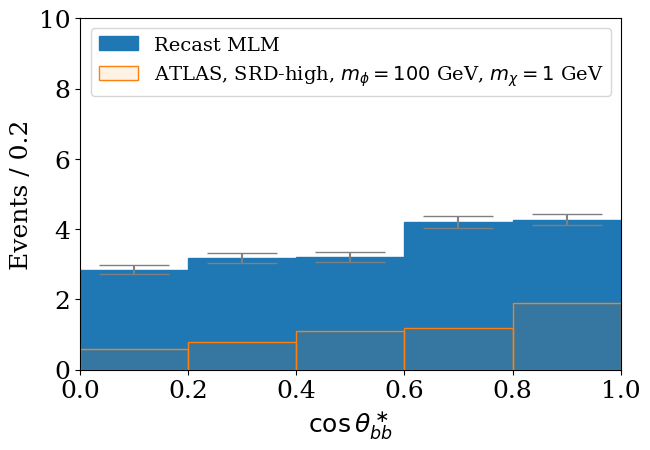

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

#Our histogram. We multiply the bins with the luminosity and the K-factor:
ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = histo_sig_final, yerr = err_sig_final, capsize = 25, ecolor='gray', width = binwidth, facecolor = 'C0', edgecolor = 'C0', label = 'Recast MLM')


#ATLAS results
ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = ATLASresults_SRDhigh_mPhi100, width = binwidth,  facecolor= (255.0/256, 128./256, 0, 0.1), edgecolor='C1',  label = r'ATLAS, SRD-high, $m_\phi = 100$ GeV, $m_\chi = 1$ GeV') 
    

ax.set_xlabel(r'$\cos \theta^\ast_{bb}$')
ax.set_ylabel(r'Events / 0.2' )
#ax.legend(loc = 4, fontsize = 14)

ax.set_xlim(0, 1) 
ax.set_ylim(0, 10)

#ax.set_xticks([])
#ax.set_yticks([])
#ax.text(x = , y =, s = r'$|\beta_R| = 0$', fontsize = 18)
plt.legend(fontsize = 14)
fig.tight_layout(pad = 2.5)
#fig.savefig('cosThetabb_SRD_2101_recast_4fs_final_mY_100GeV_mxd_1GeV.pdf')
plt.show()
plt.close()


Apply a simple, universal BDT shrinking factor; divide the # of events before and after applying the BDT cut that we can find in the ATLAS supplementary material (https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/SUSY-2018-34/tabaux_07.png):

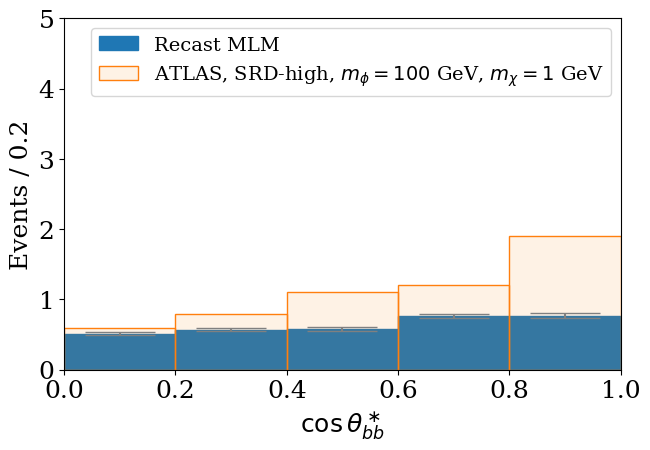

In [79]:
bdtFactor = 31.0/5.6

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

#Our histogram. We multiply the bins with the luminosity and the K-factor:

ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = histo_sig_final/bdtFactor, yerr = err_sig_final/bdtFactor, capsize = 25, ecolor='gray', width = binwidth, facecolor = 'C0', edgecolor = 'C0', label = 'Recast MLM')


#ATLAS results
ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = ATLASresults_SRDhigh_mPhi100, width = binwidth,  facecolor= (255.0/256, 128./256, 0, 0.1), edgecolor='C1',  label = r'ATLAS, SRD-high, $m_\phi = 100$ GeV, $m_\chi = 1$ GeV') 
    

ax.set_xlabel(r'$\cos \theta^\ast_{bb}$')
ax.set_ylabel(r'Events / 0.2' )
#ax.legend(loc = 4, fontsize = 14)

ax.set_xlim(0, 1) 
ax.set_ylim(0, 5)

#ax.set_xticks([])
#ax.set_yticks([])
#ax.text(x = , y =, s = r'$|\beta_R| = 0$', fontsize = 18)
plt.legend(fontsize = 14)
fig.tight_layout(pad = 2.5)
#fig.savefig('cosThetabb_SRD_2101_recast_4fs_final_mY_100GeV_mxd_1GeV.pdf')
plt.show()
plt.close()


In [20]:
print("Our histogram is", histo_sig_final, "with the total number of events being", np.sum(histo_sig_final), ". The stat error or the no of events is:", np.sqrt(np.sum(err_sig_final**2)))
print("The ATLAS histogram is", ATLASresults_SRDhigh_mPhi100, "with the total number of events being", np.sum(ATLASresults_SRDhigh_mPhi100))

Our histogram is [2.85044304 3.1682586  3.21392223 4.20735651 4.27221175] with the total number of events being 17.712192122950896 . The stat error or the no of events is: 0.33911755313639685
The ATLAS histogram is [0.6, 0.8, 1.1, 1.2, 1.9] with the total number of events being 5.6


## Plotting the contransverse mass distribution $m_{\rm CT}$:

For some reason something is wrong with the contransverse mass calculation, but what? Plot to find out the distribution between sig and $tt$

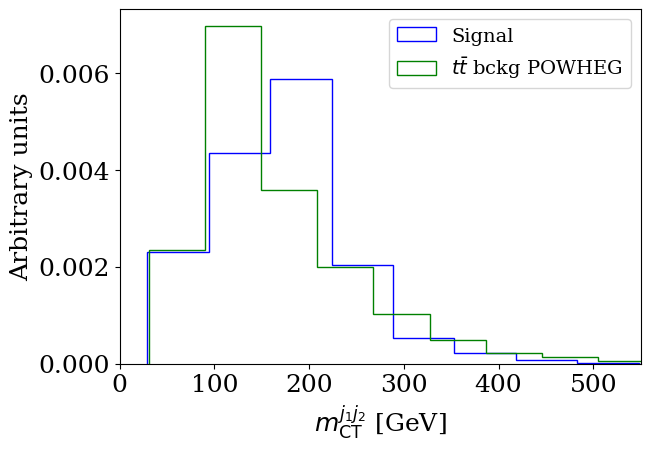

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

#ax.hist(df_bckg_tt_mg5['mCTj1j2'].to_numpy(), 15, density=True, histtype='step', color='red', label=r'$t \bar{t}$ bckg MG5')
ax.hist(df_signal['mCTj1j2'].to_numpy(), 15, density=True, histtype='step', color='blue', label=r'Signal')
ax.hist(df_bckg_tt_powheg['mCTj1j2'].to_numpy(), 15, density=True, histtype='step', color='green', label=r'$t \bar{t}$ bckg POWHEG')


ax.set_xlabel(r'$m_{\rm CT}^{j_1 j_2}$ [GeV]')
ax.set_ylabel(r'Arbitrary units' )
ax.legend(loc = 1, fontsize = 14)

ax.set_xlim(0, 550) 

fig.tight_layout(pad = 2.5)
fig.savefig('contransverse_mass_signal_ttbar_SRD_2101_mY_100GeV_mxd_1GeV.pdf')
plt.show()
plt.close()


## More plots:

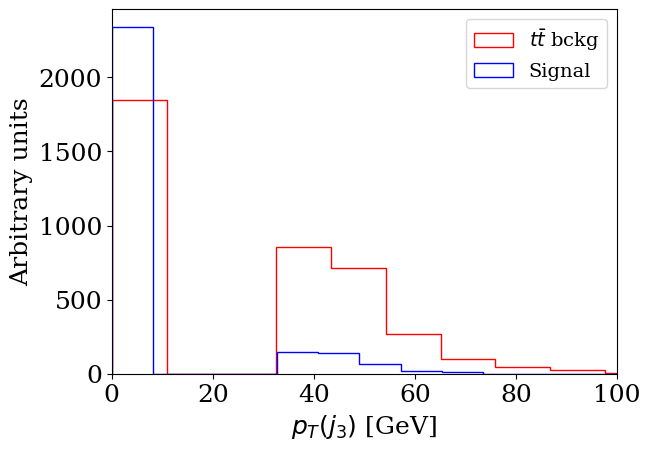

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.hist(df_bckg_tt_powheg['pT(j3)'].to_numpy(), 15, density=False, histtype='step', color='red', label=r'$t \bar{t}$ bckg')
ax.hist(df_signal['pT(j3)'].to_numpy(), 15, density=False, histtype='step', color='blue', label=r'Signal')


ax.set_xlabel(r'$p_T (j_3)$ [GeV]')
ax.set_ylabel(r'Arbitrary units' )
ax.legend(loc = 1, fontsize = 14)

ax.set_xlim(0, 100) 

fig.tight_layout(pad = 2.5)
#fig.savefig('')
plt.show()
plt.close()


In [29]:
print(np.sum([x != 0 and x > 35 for x in df_signal['pT(j3)'].to_numpy()]) + np.sum([x == 0 for x in df_signal['pT(j3)'].to_numpy()]))
print(len(df_signal['pT(j3)'].to_numpy()))
print("\n")

print(np.sum([x != 0 and x > 35 for x in df_bckg_tt_powheg['pT(j3)'].to_numpy()]) + + np.sum([x == 0 for x in df_bckg_tt_powheg['pT(j3)'].to_numpy()]))
print(len(df_bckg_tt_powheg['pT(j3)'].to_numpy()))


2728
2728


3874
3874


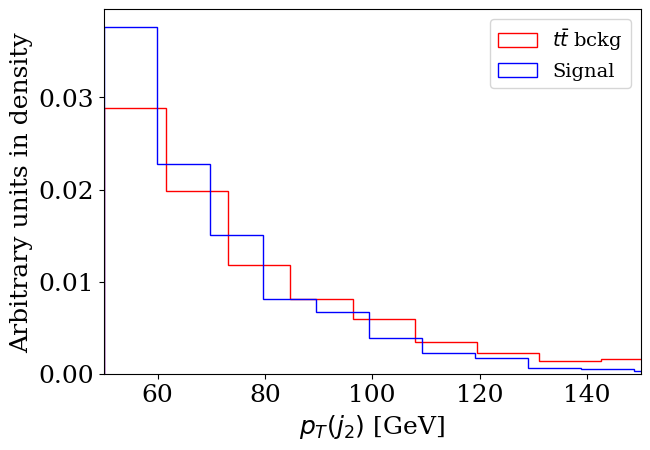

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.hist(df_bckg_tt_powheg['pT(j2)'].to_numpy(), 20, density=True, histtype='step', color='red', label=r'$t \bar{t}$ bckg')
ax.hist(df_signal['pT(j2)'].to_numpy(), 40, density=True, histtype='step', color='blue', label=r'Signal')


ax.set_xlabel(r'$p_T (j_2)$ [GeV]')
ax.set_ylabel(r'Arbitrary units in density' )
ax.legend(loc = 1, fontsize = 14)

ax.set_xlim(50, 150) 

fig.tight_layout(pad = 2.5)
#fig.savefig('')
plt.show()
plt.close()


Plot the heatmap plot of the dependence of $p_T (j_3)$ and $m_{\rm CT}$ 

## Finding the optimal value for the fake MET significance $S^{\rm MET}$:

To find the optimal value that we want to place for a fake MET significance cut (call it $S^{\rm MET}$), we can check the S/B ratio for various values of the MET significance:

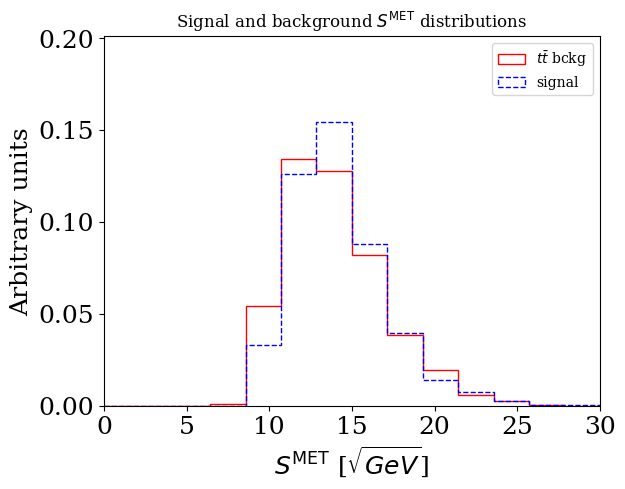

Optimal BDT Cut: 21.429
Maximum S/B Ratio: 7.222


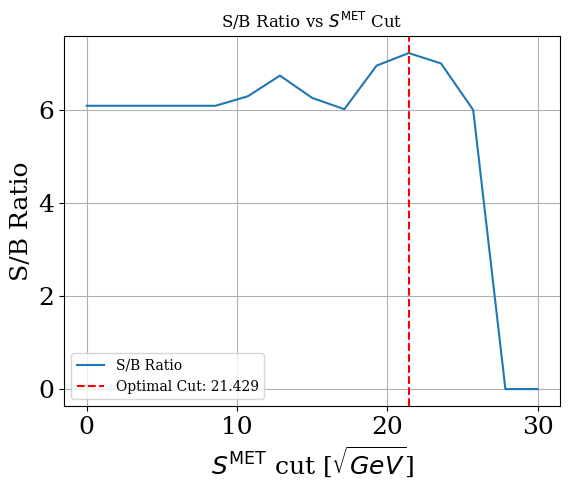

In [82]:
# *************
# Signal and background distributions
# *************

bin_edges = np.linspace(0, 30, 15)
distributions_axes = plt.gca() # get current axes
 
mc_heights = distributions_axes.hist(df_bckg_tt_powheg['S'], bins=bin_edges, color='red', 
                                        label=r'$t \bar{t}$ bckg',
                                        histtype='step', # lineplot that's unfilled
                                        density=True, # normalize to form probability density
                                        weights =  weights_bckg_tt_powheg) 
signal_heights = distributions_axes.hist(df_signal['S'], bins=bin_edges, color='blue',
                                            label= 'signal', 
                                            histtype='step', # lineplot that's unfilled
                                            density=True, # normalize to form probability density
                                            linestyle='--',
                                            weights = weights_signal) # dashed line
        
distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
plt.title(r'Signal and background $S^{\rm MET}$ distributions') # add title
distributions_axes.legend() # draw the legend
distributions_axes.set_xlabel( r'$S^{\rm MET}$ [$\sqrt{GeV}$]' ) # x-axis label

plt.show() # show the Signal and background distributions

# *************
# S/B Ratio Plot
# *************

# Define an array of BDT score cut values to test (from -1 to 1, BDT score range)
smet_cuts = np.linspace(0, 30, 15)

# Lists to store S/B ratios and corresponding cuts
sb_ratios = []

# Loop over different BDT score cut thresholds
for smet_cut in smet_cuts:


    # For every cut, build a mask to see which events stay after the given cut:

    signal_mask_current = df_signal['S'] > smet_cut
    ttbar_mask_current = df_bckg_tt_mg['S'] > smet_cut


    # Calculate the accumulated weight of the signal (S) and background (B) events remaining after the S^MET cut

    #S = np.sum(weights_signal[signal_mask_current])
    #B = np.sum(weights_bckg_tt_mg[ttbar_mask_current])

    # Or maybe the no of events is a bit more representative? I dunno...

    S = np.sum(signal_mask_current)
    B = np.sum(ttbar_mask_current)
    
    # Calculate the S/B ratio (handle case where B == 0 to avoid division by zero)
    if B > 0:
        sb_ratio = S / B
    else:
        sb_ratio = 0  # If no background events left, set ratio to 0
    
    # Append the S/B ratio for this cut
    sb_ratios.append(sb_ratio)

# Convert the list of S/B ratios to a NumPy array
sb_ratios = np.array(sb_ratios)

# Find the optimal cut with the maximum S/B ratio
optimal_cut_index = np.argmax(sb_ratios)
optimal_sMET_cut = smet_cuts[optimal_cut_index]
optimal_sb_ratio = sb_ratios[optimal_cut_index]

print(f"Optimal BDT Cut: {optimal_sMET_cut:.3f}")
print(f"Maximum S/B Ratio: {optimal_sb_ratio:.3f}")

# Plot S/B ratio as a function of the BDT cut
plt.figure()
plt.plot(smet_cuts, sb_ratios, label='S/B Ratio')
plt.axvline(optimal_sMET_cut, color='r', linestyle='--', label=f'Optimal Cut: {optimal_sMET_cut:.3f}')
plt.xlabel(r'$S^{\rm MET}$ cut [$\sqrt{GeV}$]')
plt.ylabel('S/B Ratio')
plt.title(r'S/B Ratio vs $S^{\rm MET}$ Cut')
plt.legend()
plt.grid()
plt.show()
    

Eh this is not giving a satisfactory answer...

Apply the optimal value as a cut on the arrays we have already here: 

In [26]:
#sMET_min = optimal_sMET_cut

#sMET_mask_signal = df_signal['S'].to_numpy() > sMET_min
#sMET_mask_bckg_tt = df_bckg_tt_mg5['S'].to_numpy() > sMET_min
#sMET_mask_bckg_Z = df_bckg_Z['S'].to_numpy() > sMET_min

# Concatenate these masks afterwards -- ooh fuck I am stupid. Histogram has only five elements, err also..

#To place any additional mask...Ah crap. Look, in order to do the RECAST, I SHOULDN'T PLACE ANY SMET cut! 
# Because I want to get the same numbers as ATLAS. The SMET cut doesn't throw out any events (okay 3 but whatever) from the signals.
# So keep going with arrays which have no SMET cut!
#
#histo_sig_final, err_sig_final, cosTheta_signal, weights_signal = histo_sig_final[sMET_mask_signal], err_sig_final[sMET_mask_signal], cosTheta_signal[sMET_mask_signal], weights_signal[sMET_mask_signal]

#histo_bckg_tt_final_mg, err_bckg_tt_final_mg, cosTheta_bckg_tt_mg, weights_bckg_tt_mg = histo_bckg_tt_final_mg[sMET_mask_bckg_tt], err_bckg_tt_final_mg[sMET_mask_bckg_tt], cosTheta_bckg_tt_mg[sMET_mask_bckg_tt], weights_bckg_tt_mg[sMET_mask_bckg_tt]

#histo_bckg_Z_final, err_bckg_Z_final, cosTheta_bckg_Z, weights_bckg_Z = histo_bckg_Z_final[sMET_mask_bckg_Z], err_bckg_Z_final[sMET_mask_bckg_Z], cosTheta_bckg_Z[sMET_mask_bckg_Z], weights_bckg_Z[sMET_mask_bckg_Z]

#histo_bckg_tt_final_powheg, err_bckg_tt_final_powheg, cosTheta_bckg_tt_final_powheg, weights_bckg_tt_final_powheg = bckg_tt_arrays_powheg['histo_bckg_tt_final'], bckg_tt_arrays_powheg['err_bckg_tt_final'], bckg_tt_arrays_powheg['cosTheta_bckg_tt'], bckg_tt_arrays_powheg['weights_bckg_tt']

# Do the same for the DataFrames:

#df_signal = df_signal[df_signal['S'] > sMET_min]
#df_bckg_tt_mg = df_bckg_tt_mg[df_bckg_tt_mg['S'] > sMET_min]
#df_bckg_Z = df_bckg_Z[df_bckg_Z['S'] > sMET_min]

#df_bckg_tt_powheg = df_bckg_tt_powheg[df_bckg_tt_powheg['S'] > sMET_min]



For now, since we want to recast only (and the SMET cut doesn't affect the signal events), set the SMET cut to zero!

## Training the BDT:

In [125]:
def bdt_initialize_and_train(bckg_str): 
    #What should the function return?
    #We need the masks on the SIGNAL events, from every background in principle.
    """Initialize this function for EVERY bckg that we have. This function returns a MASK.
     We will get three masks, one for every comparison to the background. Apply these masks on the signal events"""
    
    df_bckg = pd.DataFrame()
    weights_bkg = []
    weights_bkg_norm = []
    weights_signal_norm = []

    #For all the three cases, events pass through if the BDT score is LARGER than those!

    #For SRD-low, which is mPhi = 100 GeV, all of them are w = 0. This we will need to get the bounds
    wCut = 0
    wZcut = 0.10 # Set a bit higher cut
    wttCut = 0.0 # Doesn't change the situation in any way really if we set -0.1 or 0.1 or 0...
    wWcut = 0.0 # Here the cut is much more influential. 0.15 makes sense actually.

    # SRD-high : They are a bit different - These we need to get the histogram (why does ATLAS take SRD-high cuts for mPhi = 100 GeV?)
    #wZcut = -0.1
    #wttCut = 0
    #wWcut = -0.05
 

    if bckg_str == 'z':
        n_estimators = 500
        learning_rate = 0.1 # This is the optimal value from the grid 
        min_samples_leaf = 0.1 # I had it to 0.15
        tree_depth = 1 # This is the most optimal value # This might change! And should #it seems this is overtraining the model #anyway we will do the analysis again and see. Here it was 2
        df_bckg_v0 = df_bckg_Z 
        weights_bkg = np.array(weights_bckg_Z) # This is important to do. Masking and sampling with fancy indexing is not possible with lists.
        
        #Downsample the Z background, and for now, take only events with w > 0 (the w = 0 I guess should be thrown away, but w < 0? Not sure what to do with them) 
        mask_positive_weights = weights_bkg > 0

        print("The number of events with non-positive weights is", len(weights_bkg) - np.sum(mask_positive_weights))

        # Use the mask to select weights and the DataFrame entries
        df_bckg_v1 = df_bckg_v0[mask_positive_weights]  
        weights_bkg = weights_bkg[mask_positive_weights]

        # Now, sample 2000 events from the filtered data (total we have is 17261, however, 482 have 0 or negative weight )
        #size_of_bckg_sample = 17000
        #random_indices = np.random.choice(len(weights_bkg), size=size_of_bckg_sample, replace=False)

        #print(random_indices)

        #print(len(weights_bkg), len(weights_bkg[random_indices]))

        # Use the same indices for both the DataFrame and the weight array
        #df_bckg = df_bckg_v1.iloc[random_indices]  
        #weights_bkg = weights_bkg[random_indices]  

        df_bckg = df_bckg_v1

        wCut = wZcut

    elif bckg_str == 'tt_mg5':
        n_estimators = 500
        learning_rate = 0.1 #it's actually 0.1
        min_samples_leaf = 0.1 #it's actually 0.1
        tree_depth = 1
        df_bckg = df_bckg_tt_mg5
        wCut = wttCut
        weights_bkg = weights_bckg_tt_mg5


    elif bckg_str == 'tt_powheg':
        n_estimators = 500
        learning_rate = 0.1
        min_samples_leaf = 0.1
        tree_depth = 1
        df_bckg_v0 = df_bckg_tt_powheg
        wCut = wttCut

        weights_bkg = np.array(weights_bckg_tt_powheg) # This is important to do. Masking and sampling with fancy indexing is not possible with lists.
        
        #Take only events with w > 0 (the w = 0 I guess should be thrown away, but w < 0? Not sure what to do with them) 
        mask_positive_weights = weights_bkg > 0

        print("The number of events with non-positive weights is", len(weights_bkg) - np.sum(mask_positive_weights))
        
        # Use the mask to select weights and the DataFrame entries
        df_bckg = df_bckg_v0[mask_positive_weights]  
        weights_bkg = weights_bkg[mask_positive_weights]

        print("Should be zero if we filtered good", np.sum(weights_bkg < 0))

    # For the W, the parameters from the Bayesian optimization make actually sense. It separates the signal from the background quite well.
    else: #the W bckg
        # It seems these work a bit better
        #n_estimators = 500
        #learning_rate = 0.1
        #tree_depth = 1
        #min_samples_leaf = 0.1
        
        # From the Bayesian estimation
        #n_estimators = 667
        #learning_rate = 0.01782471157087136
        #min_samples_leaf = 0.05
        #tree_depth = 5 # that works, but it seems too much

        # From the PhD thesis:
        n_estimators = 500
        learning_rate = 0.5
        min_samples_leaf = 0.2
        tree_depth = 2



        wCut = wWcut
        df_bckg_v0 = df_bckg_w

        weights_bkg = np.array(weights_bckg_w) # This is important to do. Masking and sampling with fancy indexing is not possible with lists.
        
        #Take only events with w > 0 (the w = 0 I guess should be thrown away, but w < 0? Not sure what to do with them) 
        mask_positive_weights = weights_bkg > 0

        print("The number of events with non-positive weights is", len(weights_bkg) - np.sum(mask_positive_weights))
        
        # Use the mask to select weights and the DataFrame entries
        df_bckg = df_bckg_v0[mask_positive_weights]  
        weights_bkg = weights_bkg[mask_positive_weights]
    

    # Label the data 
    df_bckg['label'] = 0  # the relevant bckg in the loop
    df_signal['label'] = 1  # signal

    # Combine the datasets
    df = pd.concat([df_bckg, df_signal], ignore_index=True)

    # Before combining the weights, we need to normalize them, to avoid preferences for the higher-weight events, which is the bckg actually
    
    weights_bkg_norm = weights_bkg/np.sum(weights_bkg)
    weights_signal_norm = weights_signal/np.sum(weights_signal)


    #Combine the weights
    weights = np.concatenate([weights_bkg_norm, weights_signal_norm])


    #Any negative weights?

    print("Negative non-positive in the dataset: ", np.sum(weights <= 0))


    # All other columns are features; drop the 'label' column for the input variables
    X = df.drop(columns=['label'])
    y = df['label']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.5, random_state=42)
    
    print("np.sum of wtrain is", np.sum(w_train), "np.sum of w_test is", np.sum(w_test))

    # Separate the training and test sets for background and signal

    # Scale the weights - This could be an issue of our model not learning properly
    #w_train /= np.sum(w_train)
    #w_test /= np.sum(w_test)  # Normalize so weights sum to 1
    
    X_train_bkg = X_train[y_train == 0]
    X_train_sig = X_train[y_train == 1]
    X_test_bkg = X_test[y_test == 0]
    X_test_sig = X_test[y_test == 1]

    # Scale the data
    #scaler = StandardScaler()
    #X_train_scaled = scaler.fit_transform(X_train)
    #X_test_scaled = scaler.transform(X_test)

    # If not, just leave them:
    X_train_scaled = X_train
    X_test_scaled = X_test

    # Initialize a weak classifier
    base_estimator = DecisionTreeClassifier(max_depth = tree_depth, min_samples_leaf= min_samples_leaf)
    
    #Another base estimator that we can use:
    #base_estimator_svc=SVC(probability = True, kernel = 'linear')

    # Initialize the AdaBoost Classifier
    ada = AdaBoostClassifier(estimator = base_estimator, n_estimators = n_estimators, learning_rate = learning_rate, random_state = 42, algorithm='SAMME')

    #Another AdaBoost Classifier, with the base_estimator being the SVC - Change the number of estimators to 50 here! 500 is too much!

    #ada = AdaBoostClassifier(estimator = base_estimator_svc, n_estimators = n_estimators - 470, learning_rate = learning_rate, random_state = 42)
    

    # Train the model
    ada.fit(X_train_scaled, y_train, sample_weight = w_train) # We have changed this. It's scaled training data.

    # Make predictions
    y_pred = ada.predict(X_test_scaled) # also this. It's now the scaled data. 

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred, sample_weight = w_test)
    print(f'Accuracy: {accuracy:.4f}')

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print ("Area under ROC curve for test data: %.4f"%(roc_auc_score(y_test,
                                                    ada.decision_function(X_test))) )
    

    print("\nConfusion Matrix with the bckg {}:".format(bckg_str))
    
    conf_matrix = confusion_matrix(y_test, y_pred, sample_weight=w_test)
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    plt.close()

    y_pred = ada.predict(X_test)
    print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
    
    print(f"BDT Accuracy: {accuracy:.4f}")

    # Grid parameter estimation - repeat them once again
    param_grid = {
        'n_estimators': [300, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
        'estimator__max_depth': [1, 2, 3, 4, 5],
        'estimator__min_samples_leaf': [0.05, 0.1, 0.2, 0.5]}
    


    #grid_search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(), algorithm='SAMME'), param_grid, cv=5, scoring='roc_auc')
    
    #grid_search.fit(X_train, y_train, sample_weight = w_train)

   

    #print("Best parameters found from the grid:", grid_search.best_params_)

    # Bayesian optimization

    # Define search space for hyperparameters
    search_space = {
    "n_estimators": Integer(50, 1000),  # Number of trees
    "learning_rate": Real(0.01, 1.0, prior="log-uniform"),  # Step size
    "estimator__max_depth": Integer(1, 10),  # Tree depth
    'estimator__min_samples_leaf': Real(0.05, 0.5),
}

    # Define Bayesian search
    opt = BayesSearchCV(
        AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'),  
        search_space, 
        n_iter = 40,  # Number of evaluations
        cv = 5,  # Cross-validation folds
        scoring = "roc_auc",  # Optimization metric
        n_jobs = -1  # Use all available CPU cores
        )

    # Fit optimization
    #opt.fit(X_train, y_train, sample_weight = w_train)

    # Get the best hyperparameters
    #print("Best parameters from the Bayesian search:", opt.best_params_)

    # Cross-validation scores

    cv_results = cross_validate(ada, X_train, y_train, cv=5, 
                            scoring='accuracy', fit_params={'sample_weight': w_train}, return_train_score=True)
    
    print("Cross-Validation Scores:", cv_results['test_score'])

    scores = cross_val_score(ada, X_train, y_train, cv=5, scoring='accuracy')
    print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    # Plot the BDT scores

    #fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    #counts_train_bkg, bins_train_bkg  = np.histogram(bdt_scores_train_bkg, bins = no_of_bins, range = range_bdt, density = True) #This is how we take the counts and the bin edges
    #counts_train_sig, bins_train_sig = np.histogram(bdt_scores_train_sig, bins = no_of_bins, range = range_bdt, density = True)
    #bin_centers_bkg = 0.5 * (bins_train_bkg[1:] + bins_train_bkg[:-1])
    #bin_centers_sig = 0.5 * (bins_train_sig[1:] + bins_train_sig[:-1])


    #plt.close()

    #Maybe this one is a bit nicer

    compare_train_test(ada, X_train, y_train, X_test, y_test, bckg_str=bckg_str) # call compare_train_test that plots the train and test results


    # Plot feature importances
    importances = ada.feature_importances_
    indices = np.argsort(importances)[::-1]

    print(importances[indices])

    plt.figure()
    plt.title("Feature importances w.r.t. the {} background".format(bckg_str))
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
    #plt.xticks(range(X.shape[1]), features_by_importance, rotation=90)  # Use feature names instead of indices
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)  # Use feature names instead of indices
    #plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    plt.close()

    # After having trained the model, let's apply the BDT score cut on the signal event

    # Combine training and testing samples for signal events

    X_sig_combined = np.vstack((X_train_sig, X_test_sig))
    
    #y_sig_combined = np.hstack((y_train_sig, y_test_sig)) #But those are all ones, do I need it? Now we know it's the signal...

    # Calculate BDT scores for combined signal events
    bdt_scores_sig_combined = ada.decision_function(X_sig_combined)

    # Normalize them according to the ATLAS convention: w € [-1, 1]

    #bdt_scores_sig_combined_normalized = 2 * (bdt_scores_sig_combined - bdt_scores_sig_combined.min()) / (bdt_scores_sig_combined.max() - bdt_scores_sig_combined.min()) - 1


    bdt_scores_sig_combined_normalized = bdt_scores_sig_combined # Turn this on and off just to test something

    print(f"Min: {bdt_scores_sig_combined_normalized.min()}, Max: {bdt_scores_sig_combined_normalized.max()}")


    # Apply the BDT score cut to filter out signal events with BDT score lower than the threshold
    
    mask_BDT_sig_bckg = bdt_scores_sig_combined_normalized > wCut

    X_sig_after_cut = X_sig_combined[mask_BDT_sig_bckg]
    #y_sig_after_cut = y_sig_combined[mask_BDT_sig]



    # Print the number of signal events before and after the cut
    print("Number of signal events before cut:", len(bdt_scores_sig_combined))
    print("Number of signal events after cut:", len(X_sig_after_cut))

    # Optionally, check the distribution of the BDT scores after the cut
    
    no_of_bins = 40
    plt.figure()
    plt.hist(bdt_scores_sig_combined_normalized[mask_BDT_sig_bckg], bins=no_of_bins, alpha=0.5, color='r', density=True, histtype='stepfilled')
    plt.xlabel('BDT Score')
    plt.ylabel('No. of events')
    plt.legend(loc='best')
    plt.title('BDT Scores for Signal Events After the BDT {} Cut'.format(bckg_str))
    plt.show()
    plt.close()

    # Finally, return the mask and the BDT 

    return mask_BDT_sig_bckg, ada
    

In [32]:
np.sum(weights_bckg_tt_powheg < 0)

37

## Applying the BDT cuts on the selected events

The number of events with non-positive weights is 482
Negative non-positive in the dataset:  0
np.sum of wtrain is 1.0141282678743635 np.sum of w_test is 0.9858717321256363


/tmp/ipykernel_3140191/2428118967.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bckg['label'] = 0  # the relevant bckg in the loop


Accuracy: 0.6163

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.54      0.68      8677
           1       0.19      0.69      0.29      1318

    accuracy                           0.56      9995
   macro avg       0.55      0.62      0.49      9995
weighted avg       0.82      0.56      0.63      9995

Area under ROC curve for test data: 0.6537

Confusion Matrix with the bckg z:
[[0.27399014 0.22872862]
 [0.14956378 0.3335892 ]]


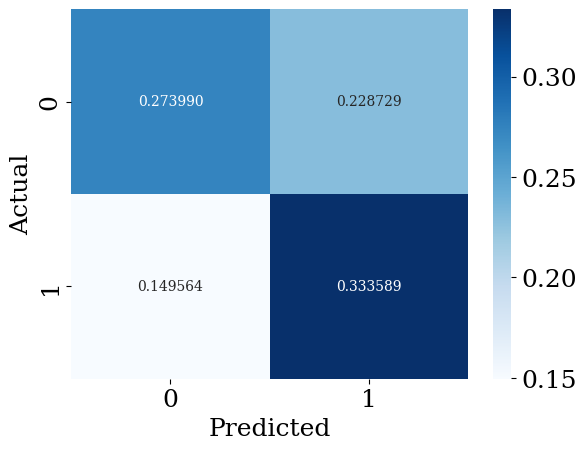

(array([0, 1]), array([5099, 4896]))
BDT Accuracy: 0.6163


/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Cross-Validation Scores: [0.5927964  0.55627814 0.5827914  0.56528264 0.56206206]
Cross-Validation Accuracy: 0.86 (+/- 0.00)
Area under signal histogram: 1.0000
Area under background histogram: 1.0000
[0.2767824  0.17976548 0.17219041 0.12639712 0.10757722 0.06001637
 0.02794536 0.01846462 0.0169821  0.00645699 0.00536224 0.00205969]


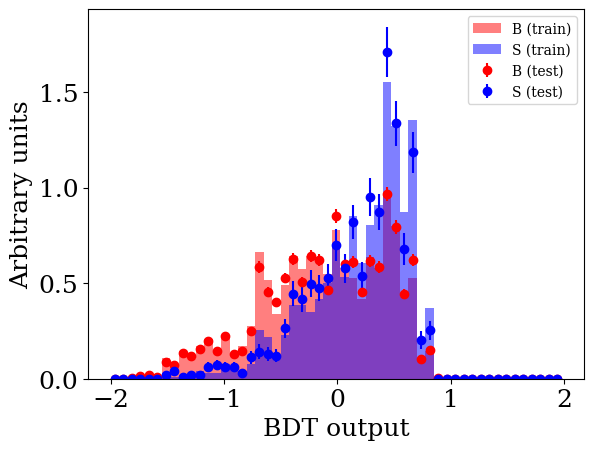

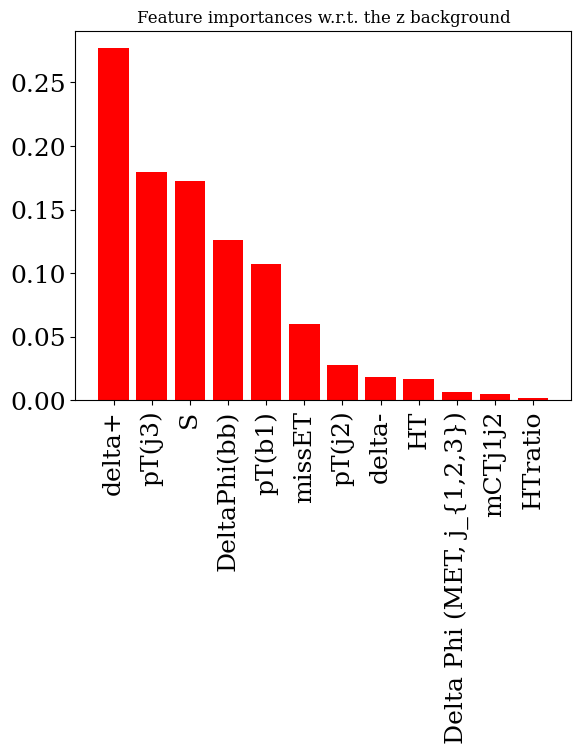

/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Min: -1.6729195418165534, Max: 0.8523459377802692
Number of signal events before cut: 2728
Number of signal events after cut: 1778


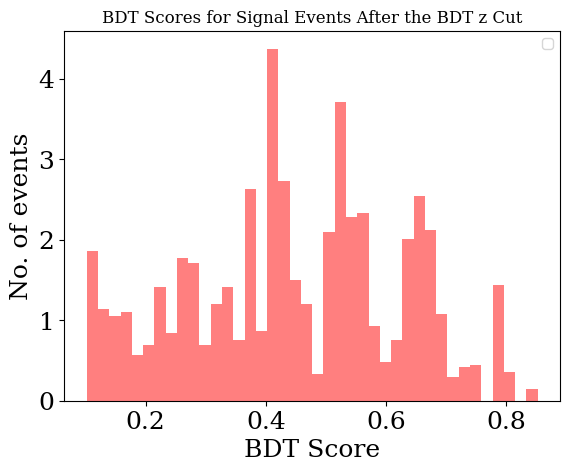

In [33]:
# Apply the function three times to get the corresponding masks
mask_BDT_sig_Zcut, ada_z = bdt_initialize_and_train('z')

It seems these values are overtraining that were analysed by our code and promised as the best BDT parameters!

In [30]:
#mask_BDT_sig_ttcut_mg5, ada_tt_mg5 = bdt_initialize_and_train('tt_mg5')

The number of events with non-positive weights is 37
Should be zero if we filtered good 0
Negative non-positive in the dataset:  0
np.sum of wtrain is 1.0031465559838055 np.sum of w_test is 0.9968534440161945


/tmp/ipykernel_3140191/39745846.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bckg['label'] = 0  # the relevant bckg in the loop


Accuracy: 0.7527

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1950
           1       0.66      0.77      0.71      1333

    accuracy                           0.75      3283
   macro avg       0.74      0.75      0.75      3283
weighted avg       0.76      0.75      0.75      3283

Area under ROC curve for test data: 0.8248

Confusion Matrix with the bckg tt_powheg:
[[0.37243967 0.13577846]
 [0.11070502 0.3779303 ]]


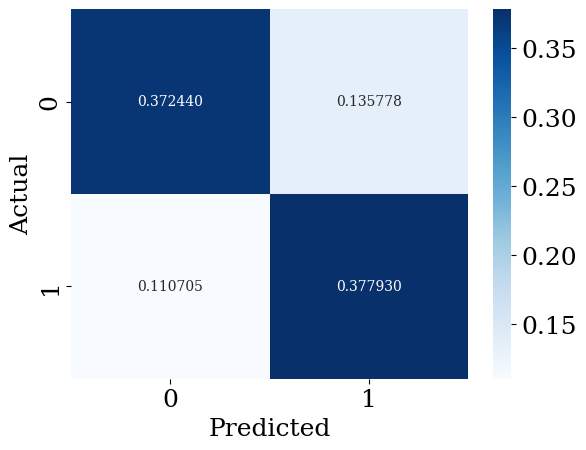

(array([0, 1]), array([1731, 1552]))
BDT Accuracy: 0.7527


/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Cross-Validation Scores: [0.75190259 0.75342466 0.74847561 0.75914634 0.75914634]
Cross-Validation Accuracy: 0.76 (+/- 0.01)
Area under signal histogram: 1.0000
Area under background histogram: 1.0000
[0.22452218 0.12938365 0.12700299 0.11267757 0.10476306 0.08947158
 0.0592887  0.04907359 0.04614033 0.03387268 0.01231985 0.01148382]


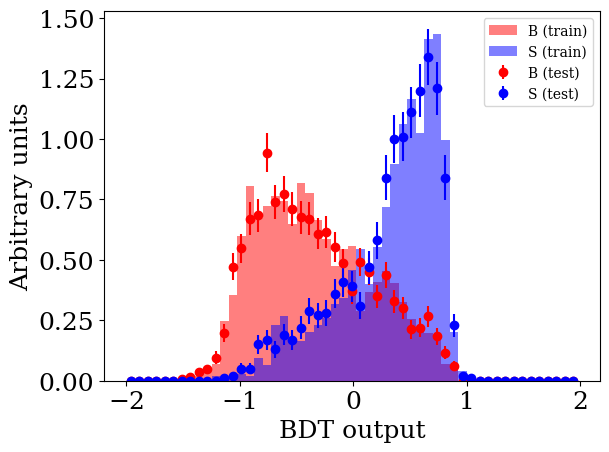

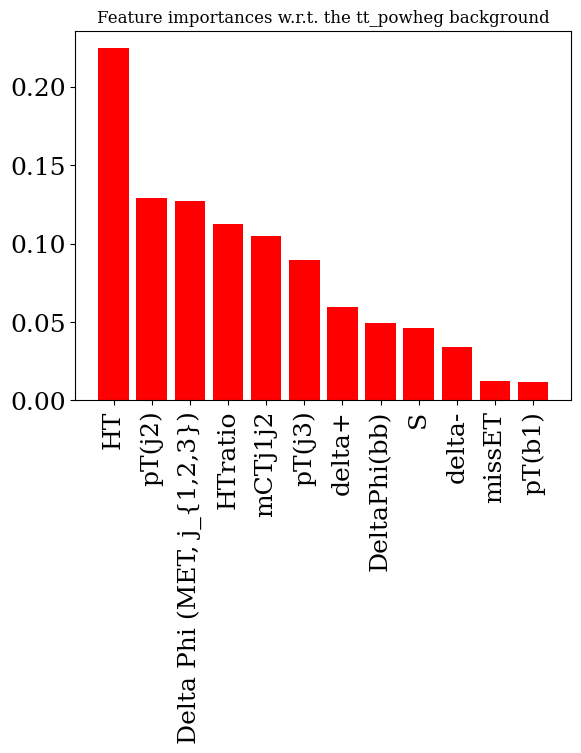

/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Min: -1.1927888222912135, Max: 1.035321118440684
Number of signal events before cut: 2728
Number of signal events after cut: 2142


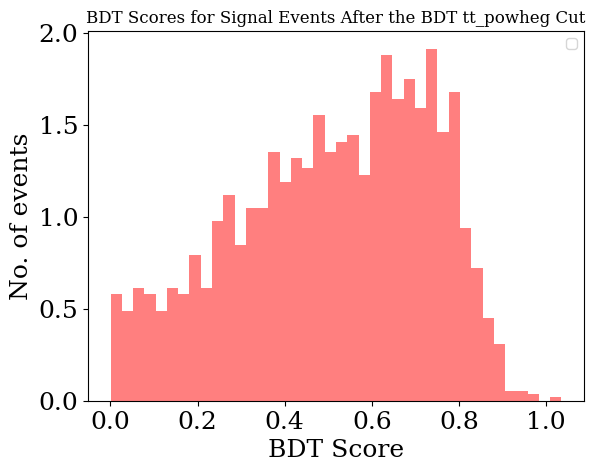

In [95]:
mask_BDT_sig_ttcut_powheg, ada_tt_powheg = bdt_initialize_and_train('tt_powheg')

The number of events with non-positive weights is 0
Negative non-positive in the dataset:  0
np.sum of wtrain is 1.0091594093341671 np.sum of w_test is 0.9908405906658329
Accuracy: 0.6077

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.62      0.70      3195
           1       0.40      0.61      0.48      1323

    accuracy                           0.62      4518
   macro avg       0.60      0.61      0.59      4518
weighted avg       0.68      0.62      0.63      4518

Area under ROC curve for test data: 0.6484

Confusion Matrix with the bckg w:
[[0.30817122 0.19768904]
 [0.19098724 0.29399309]]


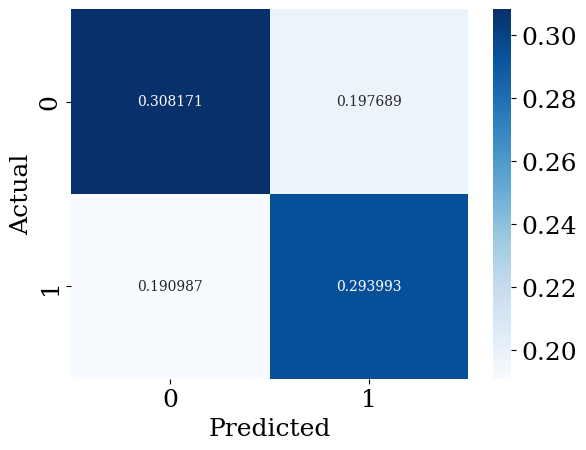

(array([0, 1]), array([2513, 2005]))
BDT Accuracy: 0.6077


/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Cross-Validation Scores: [0.60619469 0.61172566 0.60840708 0.6290144  0.60022148]
Cross-Validation Accuracy: 0.68 (+/- 0.03)
Area under signal histogram: 1.0000
Area under background histogram: 1.0000
[0.12510093 0.11575993 0.10503245 0.10314242 0.10178917 0.09642087
 0.09028273 0.08467291 0.06568225 0.05894337 0.05317296 0.        ]


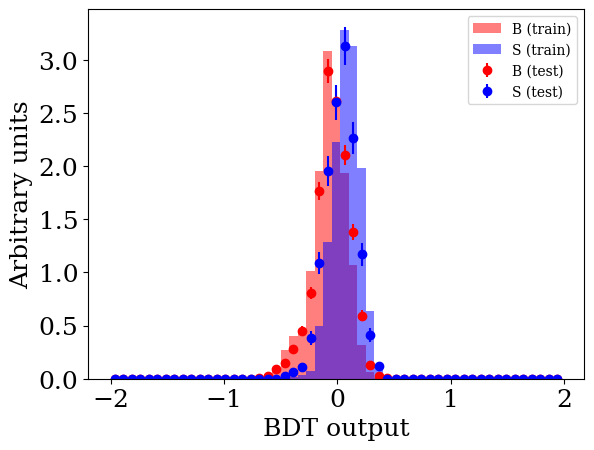

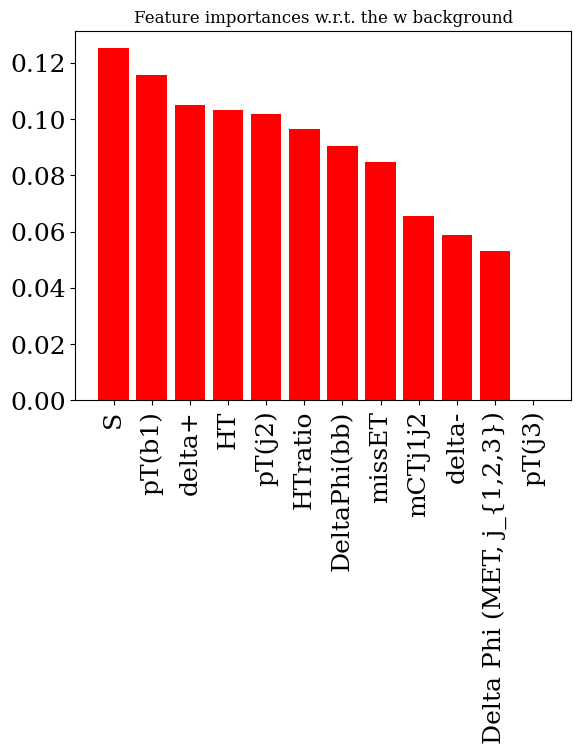

/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Min: -0.4728716941644946, Max: 0.46015660112845
Number of signal events before cut: 2728
Number of signal events after cut: 1857


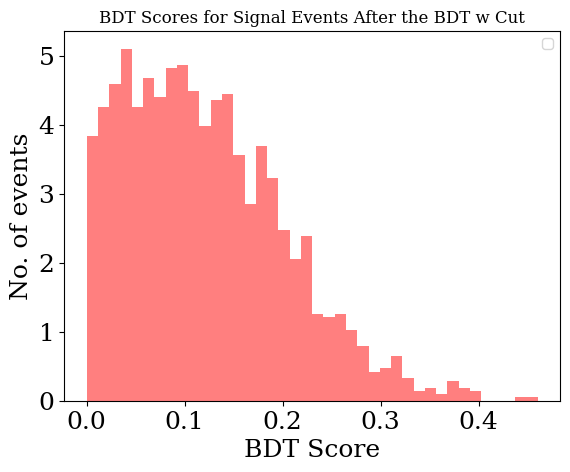

In [126]:
mask_BDT_sig_Wcut, ada_w = bdt_initialize_and_train('w')

### Validation sample

In [127]:
histo_sig_final_val = []
err_sig_final_val = [] 
cosTheta_signal_val = [] 
weights_signal_val = [] 
df_signal_val = pd.DataFrame()


#histo_sig_final_val, err_sig_final_val, cosTheta_signal_val, weights_signal_val, df_signal_val = acquire_histograms_and_dataframes('sig_validate')

#df_signal_val.to_csv('df_signal_val.csv', index=False) 
#np.savez('signal_arrays_val.npz', histo_sig_final_val = histo_sig_final_val, err_sig_final_val = err_sig_final_val, cosTheta_signal_val = cosTheta_signal_val, weights_signal_val = weights_signal_val)


If we have already the validation sample (the DataFrames and the relevant arrays), read them in here:

In [128]:
df_signal_val = pd.read_csv('df_signal_val_xptb_30.csv')
npz_signal_val = np.load('signal_arrays_val_xptb_30.npz')


histo_sig_final_val, err_sig_final_val, cosTheta_signal_val, weights_signal_val = npz_signal_val['histo_sig_final_val'], npz_signal_val['err_sig_final_val'], npz_signal_val['cosTheta_signal_val'], npz_signal_val['weights_signal_val']


In [129]:
df_signal_val

,missET,S,HT,HTratio,pT(b1),pT(j2),pT(j3),"Delta Phi (MET, j_{1,2,3})",DeltaPhi(bb),delta-,delta+,mCTj1j2
0,348.928925,15.044929,537.890198,0.785101,422.298187,115.592003,0.000000,1.082143,2.310047,-1.227904,0.250598,182.841577
1,332.454285,18.828229,311.777618,0.734877,229.118164,53.852348,0.000000,2.905664,0.196209,2.709455,0.039720,222.649179
2,268.413422,15.526288,298.863708,0.816863,244.130615,54.733089,0.000000,2.513980,0.883913,1.630067,0.256300,212.146647
3,397.726532,17.010154,546.704468,0.805371,440.299683,77.793930,0.000000,1.317226,1.833070,-0.515843,0.008704,227.880247
4,384.631042,19.479618,389.877167,0.855449,333.520142,56.357021,0.000000,3.118486,0.012427,3.106060,0.010680,275.674465
...,...,...,...,...,...,...,...,...,...,...,...,...
3082,180.034210,11.236317,256.721436,0.791547,203.207016,53.514400,0.000000,1.296438,2.003075,-0.706637,0.157920,114.011126
3083,208.506531,12.295882,287.554352,0.724393,208.302399,54.730026,0.000000,2.434152,1.201194,1.232958,0.493753,177.261774
3084,192.379700,11.633143,273.479248,0.799009,218.512299,54.966946,0.000000,1.617205,1.906671,-0.289466,0.382283,128.371757
3085,364.909241,15.339726,565.893250,0.704342,398.582153,113.878670,53.432426,1.090730,1.823296,-0.732566,0.227566,276.512994


## Validation sample

In [130]:
X_val = df_signal_val

# Get the BDT output scores for all events
bdt_outputs_tt = ada_tt_powheg.decision_function(X_val)  # or ada_tt.predict_proba(X_val)[:, 1]
bdt_outputs_z  = ada_z.decision_function(X_val)
bdt_outputs_w  = ada_w.decision_function(X_val)


wZcut = 0.10 # Set a bit higher cut
wttCut = 0.0 # Doesn't change the situation in any way really if we set -0.1 or 0.1 or 0...
wWcut = 0.0 # Here the cut is much more influential. 0.15 makes sense actually.

# Use the same cuts we had while training&testing
#wZcut = 0.0
#wttCut = 0.0  
#wWcut = 0.0 # Here the cut is much more influential. 0.15 makes sense actually.


# Apply the cuts to keep only events that pass all three criteria
tot_BDT_mask_val = (bdt_outputs_tt > wttCut) & (bdt_outputs_z > wZcut) & (bdt_outputs_w > wWcut)

# Filter the validation set
X_val_selected = X_val[tot_BDT_mask_val]

# If you need the corresponding BDT scores for selected events
bdt_tt_selected = bdt_outputs_tt[tot_BDT_mask_val]
bdt_z_selected = bdt_outputs_z[tot_BDT_mask_val]
bdt_w_selected = bdt_outputs_w[tot_BDT_mask_val]

For the training and testing sample, the total BDT mask is:

In [131]:
tot_BDT_mask = np.array(mask_BDT_sig_ttcut_powheg) & np.array(mask_BDT_sig_Zcut) & np.array(mask_BDT_sig_Wcut)

In [132]:
mask_BDT_sig_ttcut_powheg[99], mask_BDT_sig_Zcut[99], mask_BDT_sig_Wcut[99], tot_BDT_mask[99]

(True, False, True, False)

In [133]:
print("Number of evs that pass is {}, and {} evs that get cut out. We need to go down to approx 350 events at the end.".format( np.sum(tot_BDT_mask), np.sum(~tot_BDT_mask)))
print("Number of evs that pass is {}, and {} evs that get cut out. We need to go down to approx 2000 events at the end.".format( np.sum(tot_BDT_mask_val), np.sum(~tot_BDT_mask_val)))

Number of evs that pass is 955, and 1773 evs that get cut out. We need to go down to approx 350 events at the end.
Number of evs that pass is 1226, and 1861 evs that get cut out. We need to go down to approx 2000 events at the end.


The BDT reduction parameter for train-test is 2.8563840409760712 and needs to be ~5.5
The BDT reduction parameter for validation is 2.517865043898907 and needs to be ~5.5
The values of train+test histogram are: [0.97 1.18 1.07 1.54 1.44]
The values of validate histogram are: [1.   1.1  1.3  1.91 1.89]
The values of ATLAS histogram are: [0.6, 0.8, 1.1, 1.2, 1.9]
Total number of events in the ATLAS histogram is 5.6
Total number of events in the train+test histogram is 6.200914116891074
Total number of events in the validate histogram is 7.186781664157051


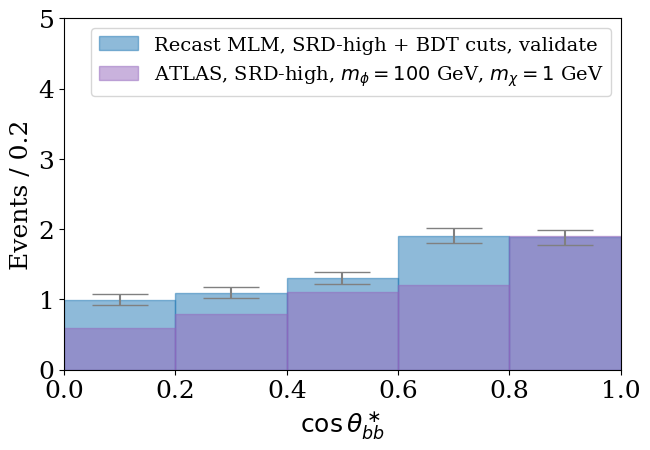

In [134]:
# That's the other thing I am not sure. Should I apply the mask only to the events that were not in the training sample, i.e. only on the test sample?
# Check this.
# Applying now the BDT masks. Note that they have the SRD_cuts mask already implemented:

cosTheta_signal_final = cosTheta_signal[tot_BDT_mask] # this is from the TRAINING + TESTING SAMPLE
weights_signal_final = weights_signal[tot_BDT_mask] # this is from the TRAINING + TESTING SAMPLE

cosTheta_signal_final_val = cosTheta_signal_val[tot_BDT_mask_val] # this is from the VALIDATION SAMPLE
weights_signal_final_val = weights_signal_val[tot_BDT_mask_val] # this is from the VALIDATION SAMPLE

print("The BDT reduction parameter for train-test is {} and needs to be ~5.5".format(np.sum(weights_signal)/np.sum(weights_signal_final)))
print("The BDT reduction parameter for validation is {} and needs to be ~5.5".format(np.sum(weights_signal_val)/np.sum(weights_signal_final_val)))


histo_signal_before_BDT, err_signal_before_BDT =                     histogram(cosTheta_signal, bins=nbins, range=(binBeginning, binEnd), weights = weights_signal*luminosity*kfactor*fivetofourFS, flow=False) 

histo_signal_after_BDT_train_test, err_signal_after_BDT_train_test = histogram(cosTheta_signal_final, bins=nbins, range=(binBeginning, binEnd), weights = weights_signal_final*luminosity*kfactor*fivetofourFS, flow=False) 

histo_signal_after_BDT_val, err_signal_after_BDT_val =               histogram(cosTheta_signal_final_val, bins=nbins, range=(binBeginning, binEnd), weights = weights_signal_final_val*luminosity*kfactor*fivetofourFS, flow=False) 


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

#Our histograms. We multiply the bins with the luminosity and the K-factor:

#ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = histo_signal_after_BDT_train_test, yerr = err_signal_after_BDT_train_test, capsize = 20, ecolor='gray', width = binwidth, facecolor = 'C1', edgecolor = 'C1', alpha = 0.5, label = 'Recast MLM, SRD-high + BDT cuts, train+test')

ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = histo_signal_after_BDT_val, yerr = err_signal_after_BDT_val, capsize = 20, ecolor='gray', width = binwidth, facecolor = 'C0', edgecolor = 'C0', alpha = 0.5, label = 'Recast MLM, SRD-high + BDT cuts, validate')


print("The values of train+test histogram are:", np.round(histo_signal_after_BDT_train_test, 2))
print("The values of validate histogram are:", np.round(histo_signal_after_BDT_val, 2))

#ATLAS results
ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = ATLASresults_SRDhigh_mPhi100, width = binwidth,  facecolor= 'C4', edgecolor='C4', alpha=0.5, label = r'ATLAS, SRD-high, $m_\phi = 100$ GeV, $m_\chi = 1$ GeV', capsize = 20) 

print("The values of ATLAS histogram are:", ATLASresults_SRDhigh_mPhi100)

print("Total number of events in the ATLAS histogram is", np.sum(ATLASresults_SRDhigh_mPhi100))
print("Total number of events in the train+test histogram is", np.sum(histo_signal_after_BDT_train_test))    
print("Total number of events in the validate histogram is", np.sum(histo_signal_after_BDT_val)) 

ax.set_xlabel(r'$\cos \theta^\ast_{bb}$')
ax.set_ylabel(r'Events / 0.2' )
#ax.legend(loc = 4, fontsize = 14)

ax.set_xlim(0, 1) 
ax.set_ylim(0, 5)

#ax.set_xticks([])
#ax.set_yticks([])
#ax.text(x = , y =, s = r'$|\beta_R| = 0$', fontsize = 18)
plt.legend(fontsize = 14)
fig.tight_layout(pad = 2.5)
#fig.savefig('cosThetabb_SRD_2101_recast_4fs_final_mY_100GeV_mxd_1GeV_SRd_and_BDTcuts.pdf')
plt.show()
plt.close()


Here as the validation sample we used the one with xptb = 30 GeV, ptj = 15 GeV, which does not fit really to the training and testing sample (xptb = 30 GeV, ptj = 0 GeV), but anyway, let's then look at the train+test histogram. One can tell it's off from the ATLAS results anyway. \\
Why don't I generate another $xptb = 30, ptj = 0$ GeV sample, as the validation sample? 

Regarding the Z background: \
As no Monte Carlo generator has been found to accurately describe
𝑍 + bbbar production in all observables, nor are these discrepancies accounted for by scale variations,
an uncertainty due to the choice of generator is evaluated by comparing the nominal samples with those
produced using aMC@NLO 2.3.3 + Pythia. After constraints from the control regions these variations
are found to be relevant only in SRD, where modelling uncertainties dominate the systematic effect on the
shape of the cosThetabb distribution. Check the paper that Jernej sent you once.

TODO: Also implement the statistical analysis (final events in the bins, pyHF stuff..Find the codes that we were using. Then maybe...Not sure.
Make something having SMEFT in mind, or a full model in mind...we did this already before. Find the old codes...)

TO-DO: Jernej suggested to check the background samples and how do they behave. Check the overall S/B and stuff..Waiting also for more $W$ events - this background is problematic!
EDIT: Indeed, the W background can introduce a large uncertainty in the final result. Once we set another sample here, the results changed drastically. Also, the $\chi^2$ fit is not promising. We are generating far more events with just inclusive jet/$b$ cuts.

Now with more $W$ events, still I'm not sure. Also, I am not sure about including W events that were generated with these hard cuts...so what should I generate more W bckg events?? pffff

# Statistical Analysis

We have some old code that we could use. 

In [38]:
import pyhf
from pyhf.contrib.viz import brazil
import math
import scipy.interpolate as interpolejsn
import scipy.optimize as optimizejsn


For SRD-high, only the last bin in the $\cos \theta_{bb}$ distribution is used. \
For SRD-low, you define a single bin $\cos \theta_{bb} > 0.6$. \
For the mediator $m_\Phi = 100$ GeV, this is **SRD-low**. What about the bckg?

In [39]:
def clsanalysis(signal, bckg, bckgerrs, datapoints):
     pyhf.set_backend("numpy")
     model = pyhf.simplemodels.hepdata_like(signal, bckg, bckgerrs)

     my_observed_counts = datapoints
     data = my_observed_counts + model.config.auxdata

     #POI estimation - Here we scan over the POI axis

     poi_vals = np.linspace(0, 9., 91) 
     """CLs_obs, CLs_exp = [pyhf.infer.hypotest(
        test_poi, data, model, test_stat="qtilde", return_expected_set=True
     ) 
     for test_poi in poi_vals]"""
     
     #We need the limits, which are arrayed from -2 sigma to +2 sigma. We get the limits in mu. Scale them with s/b.
     sigevs = np.sum(signal, axis=0)
     bckgevs = np.sum(bckg, axis=0)

     #lims = np.array(CLs_exp[0], CLs_exp[1], CLs_exp[2], CLs_exp[3], CLs_exp[4]) * sigevs/bckgevs

     soverb = sigevs/bckgevs

     obs_limit, exp_limits, (poi_tests, tests) = pyhf.infer.intervals.upperlimit(data, model, poi_vals, level=0.05, return_results=True)

     #calctype = "toybased" for toyMC.
     #print(f'expected upper limits: {exp_limits}' + 'for the Wilson coefficient:', wilcoeffs4FS[i])
     #print(f'observed upper limit : {obs_limit}', wilcoeffs4FS[i])
    
     lims = [exp_limits[0], exp_limits[1],exp_limits[2],exp_limits[3],exp_limits[4]]

     return lims, soverb

One-bin example (for the data...and the bckg...we can digitize the ATLAS plot, right?)

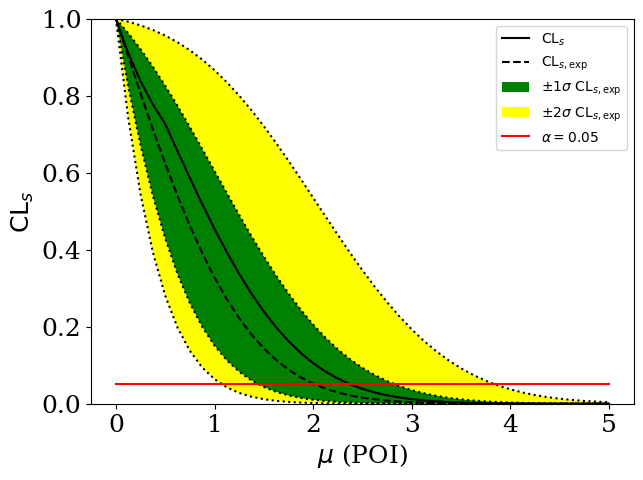

In [40]:
pyhf.set_backend("numpy")
model = pyhf.simplemodels.uncorrelated_background(
    signal=[10.0], bkg=[50.0], bkg_uncertainty=[7.0]
)
data = [55.0] + model.config.auxdata

poi_vals = np.linspace(0, 5, 41)
results = [
    pyhf.infer.hypotest(
        test_poi, data, model, test_stat="qtilde", return_expected_set=True
    )
    for test_poi in poi_vals
]

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
brazil.plot_results(poi_vals, results, ax=ax)
fig.show()

## Training, testing and validation from the new dataset 

A potential problem with the validation sample is the way it was generated. Although after the cuts we should have more-or-less the same distribution, a cut of 120 GeV for the MET might be too high, taking into account that the scalar resonance mass is 100 GeV. \
Let us for now play around and see if by using only this sample for training + testing + validation we get satisfactory results.

In [14]:
histo_sig_val = []
err_sig_val = []
cosTheta_signal_val = []
weights_signal_val = []
df_signal_val = pd.DataFrame()

histo_bckg_Z_final = []
err_bckg_Z_final = []
cosTheta_bckg_Z = []
weights_bckg_Z = []
df_bckg_Z = pd.DataFrame()

histo_bckg_tt_mg5 = []
err_bckg_tt_mg5 = []
cosTheta_bckg_tt_mg5 = []
weights_bckg_tt_mg5 = []
df_bckg_tt_mg5 = pd.DataFrame()

histo_bckg_tt_powheg = []
err_bckg_tt_powheg = []
cosTheta_bckg_tt_powheg = []
weights_bckg_tt_powheg = []
df_bckg_tt_powheg = pd.DataFrame()



df_signal_val = pd.read_csv('df_signal_val.csv')
df_bckg_Z = pd.read_csv('df_bckg_Z.csv')
df_bckg_tt_mg = pd.read_csv('df_bckg_tt_mg5.csv')
df_bckg_tt_powheg = pd.read_csv('df_bckg_tt_powheg.csv') 
df_bckg_w = pd.read_csv('df_bckg_w.csv')



npz_signal_val = np.load('signal_arrays_val.npz')
bckg_Z_arrays = np.load('bckg_Z_arrays.npz')
bckg_tt_arrays_mg5 = np.load('bckg_tt_arrays_mg5.npz')
bckg_tt_arrays_powheg = np.load('bckg_tt_arrays_powheg.npz')
bckg_w_arrays = np.load('bckg_w_arrays.npz')


histo_sig_val, err_sig_val, cosTheta_signal_val, weights_signal_val = npz_signal_val['histo_sig_final_val'], npz_signal_val['err_sig_final_val'], npz_signal_val['cosTheta_signal_val'], npz_signal_val['weights_signal_val']
histo_bckg_Z_final, err_bckg_Z_final, cosTheta_bckg_Z, weights_bckg_Z = bckg_Z_arrays['histo_bckg_Z_final'], bckg_Z_arrays['err_bckg_Z_final'], bckg_Z_arrays['cosTheta_bckg_Z'], bckg_Z_arrays['weights_bckg_Z']
histo_bckg_tt_mg5, err_bckg_tt_mg5, cosTheta_bckg_tt_mg5, weights_bckg_tt_mg5 = bckg_tt_arrays_mg5['histo_bckg_tt_mg5'], bckg_tt_arrays_mg5['err_bckg_tt_mg5'], bckg_tt_arrays_mg5['cosTheta_bckg_tt_mg5'], bckg_tt_arrays_mg5['weights_bckg_tt_mg5']
histo_bckg_tt_powheg, err_bckg_tt_powheg, cosTheta_bckg_tt_powheg, weights_bckg_tt_powheg = bckg_tt_arrays_powheg['histo_bckg_tt_powheg'], bckg_tt_arrays_powheg['err_bckg_tt_powheg'], bckg_tt_arrays_powheg['cosTheta_bckg_tt_powheg'], bckg_tt_arrays_powheg['weights_bckg_tt_powheg']
histo_bckg_w_final, err_bckg_w_final, cosTheta_bckg_w, weights_bckg_w = bckg_w_arrays['histo_bckg_w_final'], bckg_w_arrays['err_bckg_w_final'], bckg_w_arrays['cosTheta_bckg_w'], bckg_w_arrays['weights_bckg_w']



Split the DataFrame, the weights array and the cosTheta array in a consistent way (50/50 split) to have training+test


In [15]:
df_signal_val['label'] = 1 # Label ALL the signal points  as 1

df_sig_traintest, df_sig_val, weights_traintest, weights_val, cosTheta_traintest, cosTheta_val = train_test_split(
    df_signal_val, weights_signal_val, cosTheta_signal_val, test_size=0.5, random_state=42
)

#Note the difference between df_signal_val and df_sig_val - df_sig_val is only 50% of the df_signal_val

# Print the sizes to verify
print(f"df_val_1: {df_sig_traintest.shape}, df_val_2: {df_sig_val.shape}")
print(f"weights_1: {weights_traintest.shape}, weights_2: {weights_val.shape}")
print(f"cosTheta_1: {cosTheta_traintest.shape}, cosTheta_2: {cosTheta_val.shape}")


df_val_1: (4311, 13), df_val_2: (4312, 13)
weights_1: (4311,), weights_2: (4312,)
cosTheta_1: (4311,), cosTheta_2: (4312,)


In [16]:
def bdt_initialize_and_train_v2(bckg_str): 
    """Initialize this function for EVERY bckg that we have. This function returns a MASK.
     We will get three masks, one for every comparison to the background. Apply these masks on the signal events"""
    
    df_bckg = pd.DataFrame()
    weights_bkg = []
    weights_bkg_norm = []
    weights_signal_norm = []

    #For all the three cases, events pass through if the BDT score is LARGER than those!

    #For SRD-low, which is mPhi = 100 GeV, all of them are w = 0. This we will need to get the bounds
    wCut = 0
    wZcut = 0.0
    wttCut = 0.0 # Doesn't change the situation in any way really if we set -0.1 or 0.1 or 0...
    wWcut = 0.0 # Here the cut is much more influential. 0.15 makes sense actually.

    # SRD-high : They are a bit different - These we need to get the histogram (why does ATLAS take SRD-high cuts for mPhi = 100 GeV?)
    #wZcut = -0.1
    #wttCut = 0
    #wWcut = -0.05
 

    if bckg_str == 'z':
        n_estimators = 500
        learning_rate = 0.1 # This is the optimal value from the grid 
        min_samples_leaf = 0.1
        tree_depth = 1 # This is the most optimal value # This might change! And should #it seems this is overtraining the model #anyway we will do the analysis again and see.
        df_bckg_v0 = df_bckg_Z 
        weights_bkg = np.array(weights_bckg_Z) # This is important to do. Masking and sampling with fancy indexing is not possible with lists.
        
        #Downsample the Z background, and for now, take only events with w > 0 (the w = 0 I guess should be thrown away, but w < 0? Not sure what to do with them) 
        mask_positive_weights = weights_bkg > 0

        print("The number of events with non-positive weights is", len(weights_bkg) - np.sum(mask_positive_weights))

        # Use the mask to select weights and the DataFrame entries
        df_bckg_v1 = df_bckg_v0[mask_positive_weights]  
        weights_bkg = weights_bkg[mask_positive_weights]

        # Now, sample 2000 events from the filtered data (total we have is 17261, however, 482 have 0 or negative weight )
        #size_of_bckg_sample = 17000
        #random_indices = np.random.choice(len(weights_bkg), size=size_of_bckg_sample, replace=False)

        #print(random_indices)

        #print(len(weights_bkg), len(weights_bkg[random_indices]))

        # Use the same indices for both the DataFrame and the weight array
        #df_bckg = df_bckg_v1.iloc[random_indices]  
        #weights_bkg = weights_bkg[random_indices]  

        df_bckg = df_bckg_v1

        wCut = wZcut

    elif bckg_str == 'tt_mg5':
        n_estimators = 500
        learning_rate = 0.1 #it's actually 0.1
        min_samples_leaf = 0.1 #it's actually 0.1
        tree_depth = 1
        df_bckg = df_bckg_tt_mg5
        wCut = wttCut
        weights_bkg = weights_bckg_tt_mg5


    elif bckg_str == 'tt_powheg':
        n_estimators = 500
        learning_rate = 0.1
        min_samples_leaf = 0.1
        tree_depth = 1
        df_bckg_v0 = df_bckg_tt_powheg
        wCut = wttCut

        weights_bkg = np.array(weights_bckg_tt_powheg) # This is important to do. Masking and sampling with fancy indexing is not possible with lists.
        
        #Take only events with w > 0 (the w = 0 I guess should be thrown away, but w < 0? Not sure what to do with them) 
        mask_positive_weights = weights_bkg > 0

        print("The number of events with non-positive weights is", len(weights_bkg) - np.sum(mask_positive_weights))
        
        # Use the mask to select weights and the DataFrame entries
        df_bckg = df_bckg_v0[mask_positive_weights]  
        weights_bkg = weights_bkg[mask_positive_weights]

        print("Should be zero if we filtered good", np.sum(weights_bkg < 0))

    # For the W, the parameters from the Bayesian optimization make actually sense. It separates the signal from the background quite well.
    else: #the W bckg
        # From the ATLAS PhD Thesis
        #n_estimators = 500
        #learning_rate = 0.1
        #tree_depth = 1
        #min_samples_leaf = 0.1
        
        # From the Bayesian estimation
        #n_estimators = 667
        #learning_rate = 0.01782471157087136
        #min_samples_leaf = 0.05
        #tree_depth = 5 # that works, but it seems too much

        # From the grid results:
        n_estimators = 500
        learning_rate = 0.5
        min_samples_leaf = 0.2
        tree_depth = 2



        wCut = wWcut
        df_bckg_v0 = df_bckg_w

        weights_bkg = np.array(weights_bckg_w) # This is important to do. Masking and sampling with fancy indexing is not possible with lists.
        
        #Take only events with w > 0 (the w = 0 I guess should be thrown away, but w < 0? Not sure what to do with them) 
        mask_positive_weights = weights_bkg > 0

        print("The number of events with non-positive weights is", len(weights_bkg) - np.sum(mask_positive_weights))
        
        # Use the mask to select weights and the DataFrame entries
        df_bckg = df_bckg_v0[mask_positive_weights]  
        weights_bkg = weights_bkg[mask_positive_weights]
    

    # Label the data 
    df_bckg['label'] = 0  # the relevant bckg in the loop
    df_sig_traintest['label'] = 1  # signal

    # Combine the datasets
    df = pd.concat([df_bckg, df_sig_traintest], ignore_index=True)

    # Before combining the weights, we need to normalize them, to avoid preferences for the higher-weight events, which is the bckg actually
    
    weights_bkg_norm = weights_bkg/np.sum(weights_bkg)
    weights_signal_norm = weights_traintest/np.sum(weights_traintest)


    #Combine the weights
    weights = np.concatenate([weights_bkg_norm, weights_signal_norm])


    #Any negative weights?

    print("Negative non-positive in the dataset: ", np.sum(weights <= 0))


    # All other columns are features; drop the 'label' column for the input variables
    X = df.drop(columns=['label'])
    y = df['label']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.5, random_state=42)
    
    print("np.sum of wtrain is", np.sum(w_train), "np.sum of w_test is", np.sum(w_test))

    # Separate the training and test sets for background and signal

    # Scale the weights - This could be an issue of our model not learning properly
    #w_train /= np.sum(w_train)
    #w_test /= np.sum(w_test)  # Normalize so weights sum to 1
    
    X_train_bkg = X_train[y_train == 0]
    X_train_sig = X_train[y_train == 1]
    X_test_bkg = X_test[y_test == 0]
    X_test_sig = X_test[y_test == 1]

    # Scale the data
    #scaler = StandardScaler()
    #X_train_scaled = scaler.fit_transform(X_train)
    #X_test_scaled = scaler.transform(X_test)

    # If not, just leave them:
    X_train_scaled = X_train
    X_test_scaled = X_test

    # Initialize a weak classifier
    base_estimator = DecisionTreeClassifier(max_depth = tree_depth, min_samples_leaf= min_samples_leaf)
    
    #Another base estimator that we can use:
    #base_estimator_svc=SVC(probability = True, kernel = 'linear')

    # Initialize the AdaBoost Classifier
    ada = AdaBoostClassifier(estimator = base_estimator, n_estimators = n_estimators, learning_rate = learning_rate, random_state = 42, algorithm='SAMME')

    #Another AdaBoost Classifier, with the base_estimator being the SVC - Change the number of estimators to 50 here! 500 is too much!

    #ada = AdaBoostClassifier(estimator = base_estimator_svc, n_estimators = n_estimators - 470, learning_rate = learning_rate, random_state = 42)
    

    # Train the model
    ada.fit(X_train_scaled, y_train, sample_weight = w_train) # We have changed this. It's scaled training data.

    # Make predictions
    y_pred = ada.predict(X_test_scaled) # also this. It's now the scaled data. 

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred, sample_weight = w_test)
    print(f'Accuracy: {accuracy:.4f}')

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print ("Area under ROC curve for test data: %.4f"%(roc_auc_score(y_test,
                                                    ada.decision_function(X_test))) )
    

    print("\nConfusion Matrix with the bckg {}:".format(bckg_str))
    
    conf_matrix = confusion_matrix(y_test, y_pred, sample_weight=w_test)
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    plt.close()

    y_pred = ada.predict(X_test)
    print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
    
    print(f"BDT Accuracy: {accuracy:.4f}")

    # Grid parameter estimation - repeat them once again
    param_grid = {
        'n_estimators': [300, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
        'estimator__max_depth': [1, 2, 3, 4, 5],
        'estimator__min_samples_leaf': [0.05, 0.1, 0.2, 0.5]}
    


    #grid_search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(), algorithm='SAMME'), param_grid, cv=5, scoring='roc_auc')
    
    #grid_search.fit(X_train, y_train, sample_weight = w_train)

   

    #print("Best parameters found from the grid:", grid_search.best_params_)

    # Bayesian optimization

    # Define search space for hyperparameters
    search_space = {
    "n_estimators": Integer(50, 1000),  # Number of trees
    "learning_rate": Real(0.01, 1.0, prior="log-uniform"),  # Step size
    "estimator__max_depth": Integer(1, 10),  # Tree depth
    'estimator__min_samples_leaf': Real(0.05, 0.5),
}

    # Define Bayesian search
    opt = BayesSearchCV(
        AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'),  
        search_space, 
        n_iter = 40,  # Number of evaluations
        cv = 5,  # Cross-validation folds
        scoring = "roc_auc",  # Optimization metric
        n_jobs = -1  # Use all available CPU cores
        )

    # Fit optimization
    #opt.fit(X_train, y_train, sample_weight = w_train)

    # Get the best hyperparameters
    #print("Best parameters from the Bayesian search:", opt.best_params_)

    # Cross-validation scores

    cv_results = cross_validate(ada, X_train, y_train, cv=5, 
                            scoring='accuracy', fit_params={'sample_weight': w_train}, return_train_score=True)
    
    print("Cross-Validation Scores:", cv_results['test_score'])

    scores = cross_val_score(ada, X_train, y_train, cv=5, scoring='accuracy')
    print("Cross-Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    # Plot the BDT scores

    #fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    #counts_train_bkg, bins_train_bkg  = np.histogram(bdt_scores_train_bkg, bins = no_of_bins, range = range_bdt, density = True) #This is how we take the counts and the bin edges
    #counts_train_sig, bins_train_sig = np.histogram(bdt_scores_train_sig, bins = no_of_bins, range = range_bdt, density = True)
    #bin_centers_bkg = 0.5 * (bins_train_bkg[1:] + bins_train_bkg[:-1])
    #bin_centers_sig = 0.5 * (bins_train_sig[1:] + bins_train_sig[:-1])


    #plt.close()

    #Maybe this one is a bit nicer

    compare_train_test(ada, X_train, y_train, X_test, y_test) # call compare_train_test that plots the train and test results


    # Plot feature importances
    importances = ada.feature_importances_
    indices = np.argsort(importances)[::-1]

    print(importances[indices])

    plt.figure()
    plt.title("Feature importances w.r.t. the {} background".format(bckg_str))
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
    #plt.xticks(range(X.shape[1]), features_by_importance, rotation=90)  # Use feature names instead of indices
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)  # Use feature names instead of indices
    #plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    plt.close()

    # After having trained the model, let's apply the BDT score cut on the signal event

    # Combine training and testing samples for signal events

    X_sig_combined = np.vstack((X_train_sig, X_test_sig))
    
    #y_sig_combined = np.hstack((y_train_sig, y_test_sig)) #But those are all ones, do I need it? Now we know it's the signal...

    # Calculate BDT scores for combined signal events
    bdt_scores_sig_combined = ada.decision_function(X_sig_combined)

    # Normalize them according to the ATLAS convention: w € [-1, 1]

    #bdt_scores_sig_combined_normalized = 2 * (bdt_scores_sig_combined - bdt_scores_sig_combined.min()) / (bdt_scores_sig_combined.max() - bdt_scores_sig_combined.min()) - 1


    bdt_scores_sig_combined_normalized = bdt_scores_sig_combined # Turn this on and off just to test something

    print(f"Min: {bdt_scores_sig_combined_normalized.min()}, Max: {bdt_scores_sig_combined_normalized.max()}")


    # Apply the BDT score cut to filter out signal events with BDT score lower than the threshold
    
    mask_BDT_sig_bckg = bdt_scores_sig_combined_normalized > wCut

    X_sig_after_cut = X_sig_combined[mask_BDT_sig_bckg]
    #y_sig_after_cut = y_sig_combined[mask_BDT_sig]



    # Print the number of signal events before and after the cut
    print("Number of signal events before cut:", len(bdt_scores_sig_combined))
    print("Number of signal events after cut:", len(X_sig_after_cut))

    # Optionally, check the distribution of the BDT scores after the cut
    
    no_of_bins = 40
    plt.figure()
    plt.hist(bdt_scores_sig_combined_normalized[mask_BDT_sig_bckg], bins=no_of_bins, alpha=0.5, color='r', density=True, histtype='stepfilled')
    plt.xlabel('BDT Score')
    plt.ylabel('No. of events')
    plt.legend(loc='best')
    plt.title('BDT Scores for Signal Events After the BDT {} Cut'.format(bckg_str))
    plt.show()
    plt.close()

    # Finally, return the mask and the BDT 

    return mask_BDT_sig_bckg, ada
    

The number of events with non-positive weights is 482
Negative non-positive in the dataset:  0
np.sum of wtrain is 1.012042716312231 np.sum of w_test is 0.9879572836877689


/tmp/ipykernel_1642446/1785732154.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bckg['label'] = 0  # the relevant bckg in the loop


Accuracy: 0.6464

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.53      0.67      8698
           1       0.28      0.77      0.41      2088

    accuracy                           0.57     10786
   macro avg       0.59      0.65      0.54     10786
weighted avg       0.78      0.57      0.62     10786

Area under ROC curve for test data: 0.6773

Confusion Matrix with the bckg z:
[[0.26775617 0.23586448]
 [0.1134304  0.37090622]]


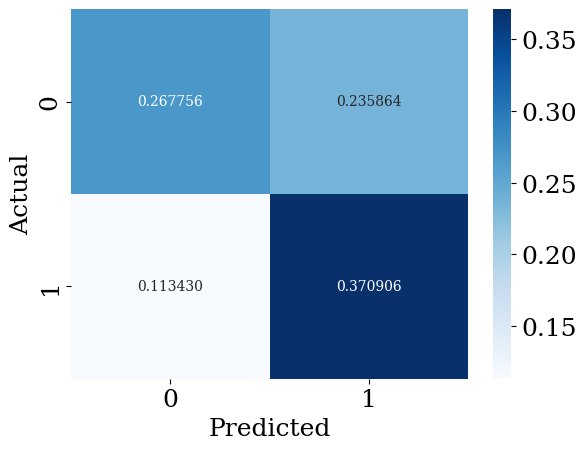

(array([0, 1]), array([5087, 5699]))
BDT Accuracy: 0.6464


/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Cross-Validation Scores: [0.57275255 0.54983774 0.58599907 0.594344   0.57626333]
Cross-Validation Accuracy: 0.79 (+/- 0.00)
Area under signal histogram: 1.0000
Area under background histogram: 1.0000
[0.24641852 0.22015994 0.14059573 0.12286283 0.09817738 0.04754253
 0.040217   0.03809935 0.01688782 0.01475005 0.01157617 0.00271269]


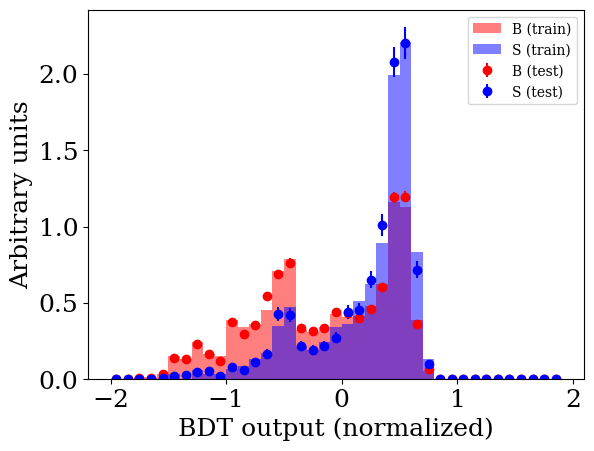

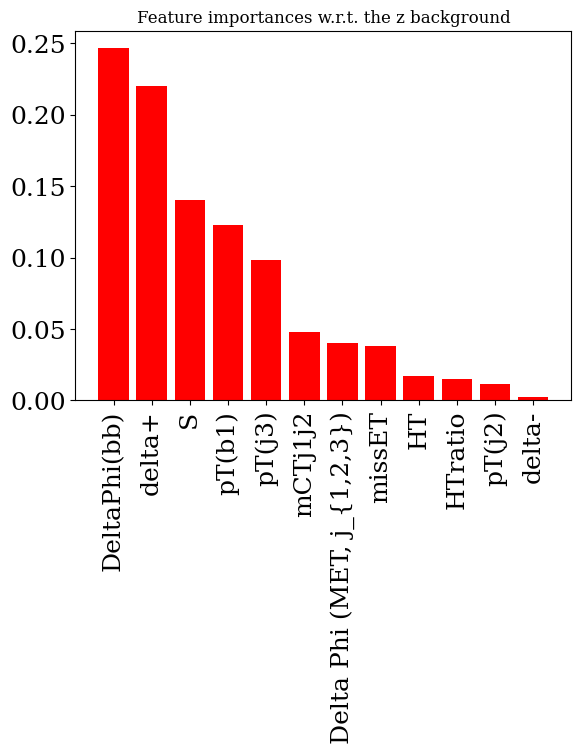

/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Min: -1.5046185837541066, Max: 0.7871164903788935
Number of signal events before cut: 4311
Number of signal events after cut: 3280


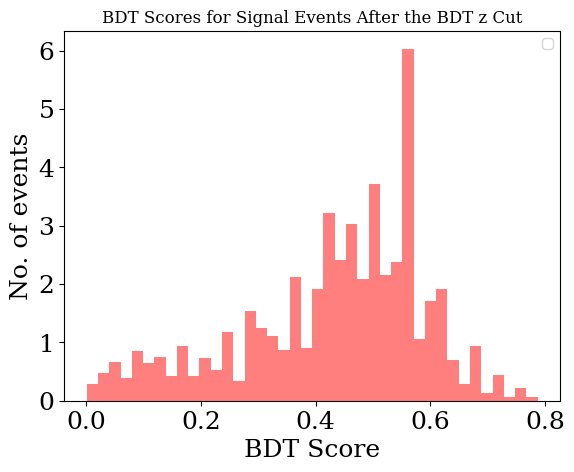

In [17]:
mask_BDT_sig_Zcut, ada_z = bdt_initialize_and_train_v2('z')

The number of events with non-positive weights is 0
Negative non-positive in the dataset:  0
np.sum of wtrain is 0.9999067414369229 np.sum of w_test is 1.0000932585630768


Accuracy: 0.6870

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.62      1429
           1       0.75      0.73      0.74      2139

    accuracy                           0.69      3568
   macro avg       0.68      0.68      0.68      3568
weighted avg       0.70      0.69      0.69      3568

Area under ROC curve for test data: 0.7199

Confusion Matrix with the bckg w:
[[0.3240258  0.17989278]
 [0.133154   0.36302068]]


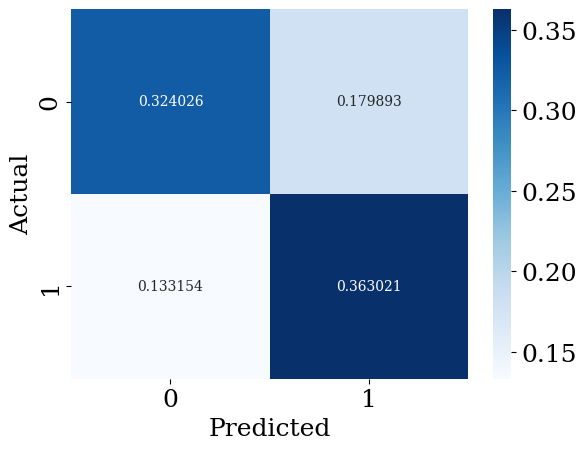

(array([0, 1]), array([1484, 2084]))
BDT Accuracy: 0.6870


/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Cross-Validation Scores: [0.66666667 0.71288515 0.68863955 0.69845722 0.66058906]
Cross-Validation Accuracy: 0.70 (+/- 0.01)
Area under signal histogram: 1.0000
Area under background histogram: 1.0000
[0.13900298 0.12269139 0.10620041 0.09684101 0.0952891  0.08840539
 0.087464   0.07411893 0.06176912 0.05660015 0.05152514 0.02009238]


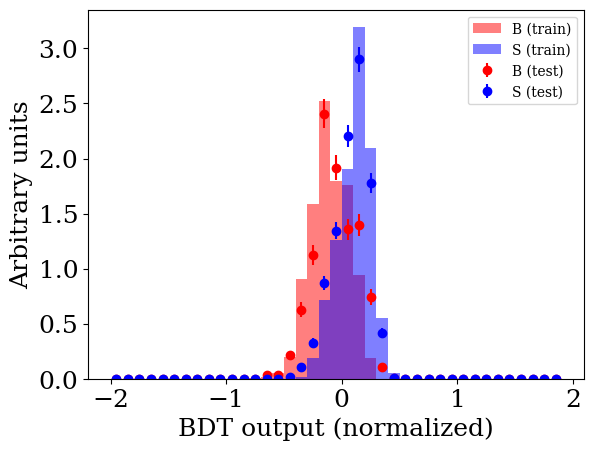

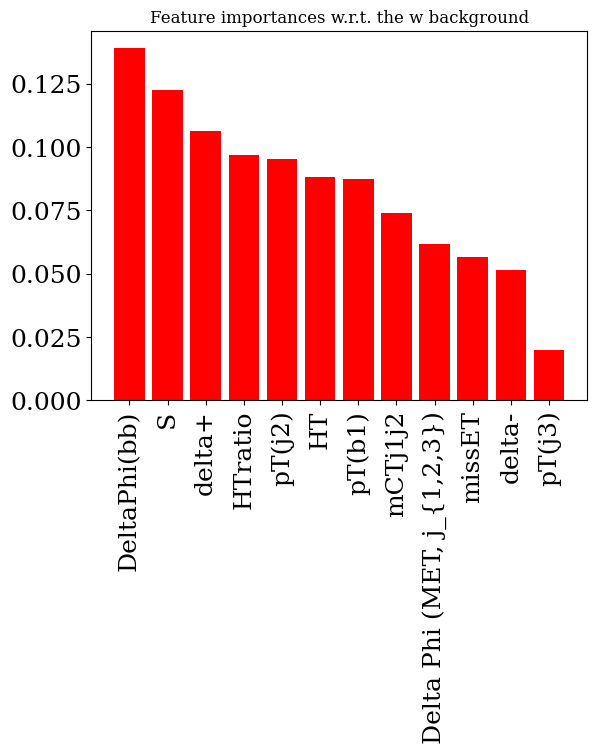

/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Min: -0.4782152483001666, Max: 0.4743200127343463
Number of signal events before cut: 4311
Number of signal events after cut: 3260


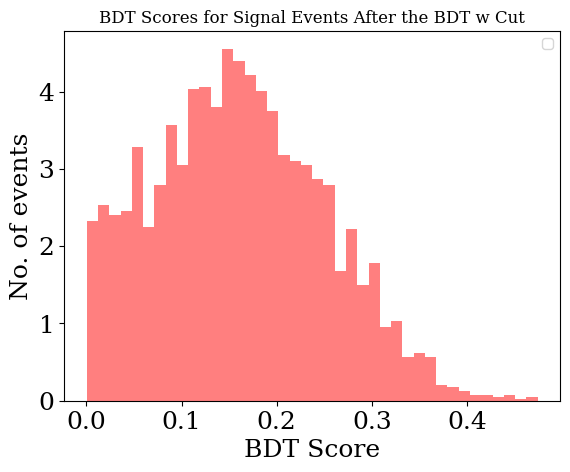

In [18]:
mask_BDT_sig_Wcut, ada_w = bdt_initialize_and_train_v2('w')

The number of events with non-positive weights is 37
Should be zero if we filtered good 0
Negative non-positive in the dataset:  0
np.sum of wtrain is 1.000176479769645 np.sum of w_test is 0.9998235202303549


/tmp/ipykernel_1642446/1785732154.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bckg['label'] = 0  # the relevant bckg in the loop


Accuracy: 0.7615

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      1922
           1       0.77      0.79      0.78      2152

    accuracy                           0.76      4074
   macro avg       0.76      0.76      0.76      4074
weighted avg       0.76      0.76      0.76      4074

Area under ROC curve for test data: 0.8243

Confusion Matrix with the bckg tt_powheg:
[[0.36491923 0.13570622]
 [0.10276064 0.39643742]]


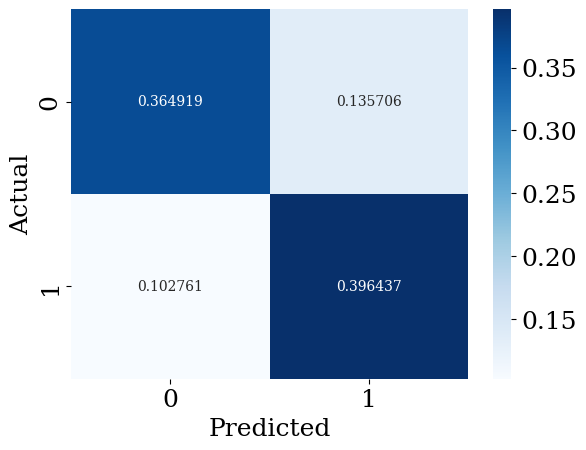

(array([0, 1]), array([1844, 2230]))
BDT Accuracy: 0.7615


/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Cross-Validation Scores: [0.77300613 0.74969325 0.72392638 0.77791411 0.75184275]
Cross-Validation Accuracy: 0.76 (+/- 0.03)
Area under signal histogram: 1.0000
Area under background histogram: 1.0000
[0.17625165 0.13991571 0.13434746 0.12977133 0.12678686 0.08417324
 0.07196124 0.06043356 0.0434089  0.02375799 0.00919206 0.        ]


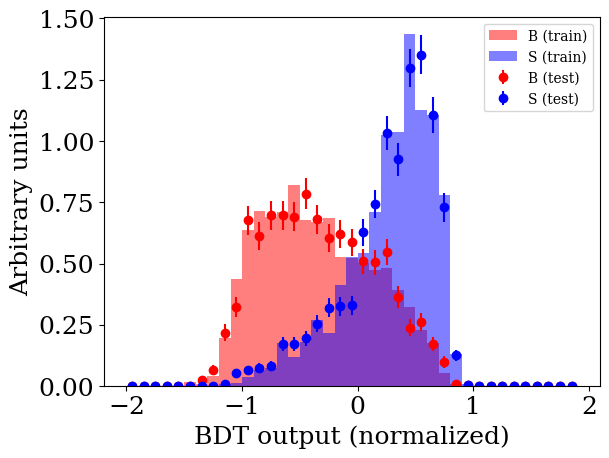

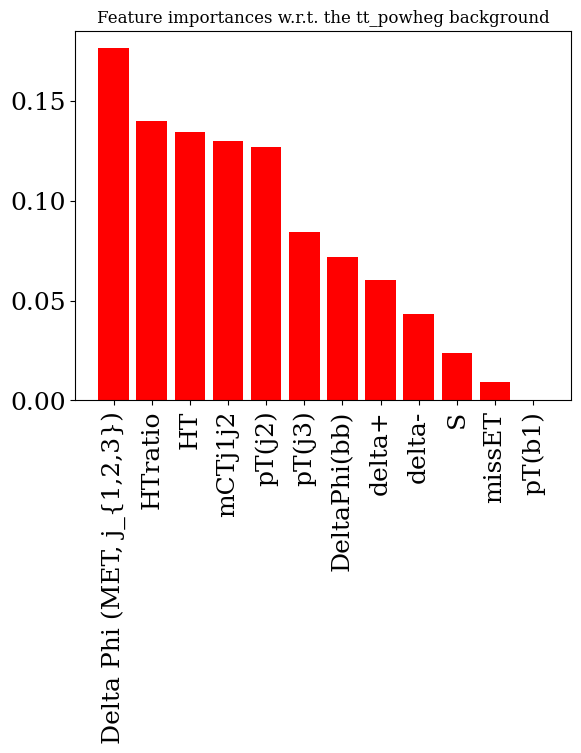

/home/armankorajac/py3VirtEnv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Min: -1.1879684761967222, Max: 0.9742667141544229
Number of signal events before cut: 4311
Number of signal events after cut: 3414


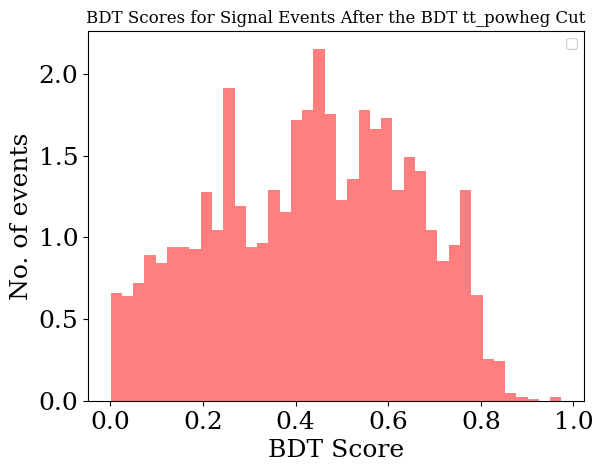

In [19]:
mask_BDT_sig_ttcut_powheg, ada_tt_powheg = bdt_initialize_and_train_v2('tt_powheg')

In [20]:
tot_BDT_mask = np.array(mask_BDT_sig_ttcut_powheg) & np.array(mask_BDT_sig_Zcut) & np.array(mask_BDT_sig_Wcut)

### Validation

In [21]:
X_val = df_sig_val.drop(columns=['label'])

# Get the BDT output scores for all events
bdt_outputs_tt = ada_tt_powheg.decision_function(X_val)  # or ada_tt.predict_proba(X_val)[:, 1]
bdt_outputs_z  = ada_z.decision_function(X_val)
bdt_outputs_w  = ada_w.decision_function(X_val)

# Use the same cuts we had while training&testing
wZcut = 0.0
wttCut = 0.0  
wWcut = 0.0 # Here the cut is much more influential. 0.15 makes sense actually.

# Apply the cuts to keep only events that pass all three criteria
tot_BDT_mask_val = (bdt_outputs_tt > wttCut) & (bdt_outputs_z > wZcut) & (bdt_outputs_w > wWcut)

# Filter the validation set
X_val_selected = X_val[tot_BDT_mask_val]

# If you need the corresponding BDT scores for selected events
bdt_tt_selected = bdt_outputs_tt[tot_BDT_mask_val]
bdt_z_selected = bdt_outputs_z[tot_BDT_mask_val]
bdt_w_selected = bdt_outputs_w[tot_BDT_mask_val]

In [22]:
print(len(tot_BDT_mask_val), np.sum(tot_BDT_mask_val), np.sum(tot_BDT_mask_val)/len(tot_BDT_mask_val))

4312 2428 0.5630797773654916


### Check the results on the validation sample (from the new dataset):

The BDT reduction parameter for train-test is 2.1872238450911112 and needs to be ~5.5
The BDT reduction parameter for validation is 1.7759559462583643 and needs to be ~5.5
The values of the train+test histogram are: [0.56 0.68 0.79 1.04 1.09]
The values of the validation histogram are: [0.66 0.8  1.   1.34 1.31]
The values of ATLAS histogram are: [0.6, 0.8, 1.1, 1.2, 1.9]


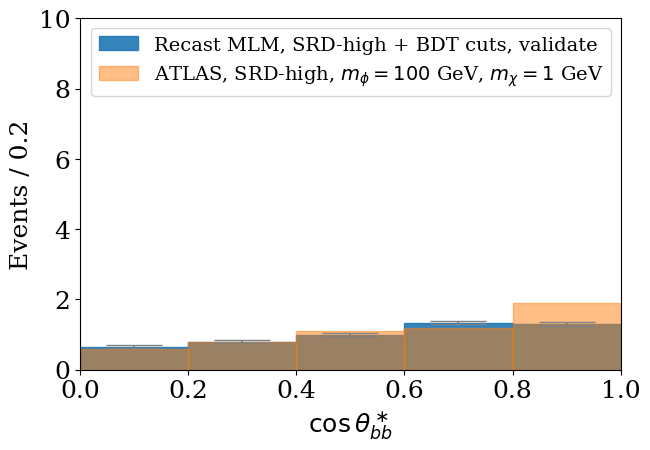

In [26]:
# That's the other thing I am not sure. Should I apply the mask only to the events that were not in the training sample, i.e. only on the test sample?
# Check this.


weights_sum_before_traintest = np.sum(weights_traintest)
weights_sum_before_val = np.sum(weights_val)

# Let us save the histograms before applying the BDT cuts, for the validation sample:

histo_signal_before_BDT_val, err_signal_before_BDT_val = histogram(cosTheta_val, bins=nbins, range=(binBeginning, binEnd), weights = weights_val*luminosity*kfactor*fivetofourFS, flow=False) 


# Applying now the BDT masks. Note that they have the SRD_cuts mask already implemented:
cosTheta_traintest_final = cosTheta_traintest[tot_BDT_mask] # this is from the TRAINING + TESTING SAMPLE
weights_traintest_final = weights_traintest[tot_BDT_mask] # this is from the TRAINING + TESTING SAMPLE

cosTheta_val_final = cosTheta_val[tot_BDT_mask_val] # this is from the VALIDATION SAMPLE
weights_val_final = weights_val[tot_BDT_mask_val] # this is from the VALIDATION SAMPLE


weights_sum_after_traintest = np.sum(weights_traintest_final)
weights_sum_after_val = np.sum(weights_val_final)


print("The BDT reduction parameter for train-test is {} and needs to be ~5.5".format(weights_sum_before_traintest/weights_sum_after_traintest))
print("The BDT reduction parameter for validation is {} and needs to be ~5.5".format(weights_sum_before_val/weights_sum_after_val))



histo_signal_after_BDT_train_test, err_signal_after_BDT_train_test = histogram(cosTheta_traintest_final, bins=nbins, range=(binBeginning, binEnd), weights = weights_traintest_final*luminosity*kfactor*fivetofourFS, flow=False) 

histo_signal_after_BDT_val, err_signal_after_BDT_val =               histogram(cosTheta_val_final, bins=nbins, range=(binBeginning, binEnd), weights = weights_val_final*luminosity*kfactor*fivetofourFS, flow=False) 


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

#Our histogram. We multiply the bins with the luminosity and the K-factor:

#ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = histo_signal_after_BDT_train_test, yerr = err_signal_after_BDT_train_test, capsize = 20, ecolor='gray', width = binwidth, facecolor = 'C1', edgecolor = 'C1', alpha = 0.5, label = 'Recast MLM, SRD-high + BDT cuts, train+test')


#ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = histo_signal_before_BDT_val, yerr = err_signal_before_BDT_val, capsize = 20, ecolor='gray', width = binwidth, facecolor = 'C1', edgecolor = 'C1', alpha = 0.9, label = 'Recast MLM, SRD-high, validate')

ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = histo_signal_after_BDT_val, yerr = err_signal_after_BDT_val, capsize = 20, ecolor='gray', width = binwidth, facecolor = 'C0', edgecolor = 'C0', alpha = 0.9, label = 'Recast MLM, SRD-high + BDT cuts, validate')



print("The values of the train+test histogram are:", np.round(histo_signal_after_BDT_train_test, 2))

print("The values of the validation histogram are:", np.round(histo_signal_after_BDT_val, 2))

#ATLAS results
ax.bar([binBeginning + binwidth/2 + i*binwidth for i in range(nbins)], height = ATLASresults_SRDhigh_mPhi100, width = binwidth,  facecolor= 'C1', edgecolor='C1', alpha=0.5, label = r'ATLAS, SRD-high, $m_\phi = 100$ GeV, $m_\chi = 1$ GeV', capsize = 20) 

print("The values of ATLAS histogram are:", ATLASresults_SRDhigh_mPhi100)
  

ax.set_xlabel(r'$\cos \theta^\ast_{bb}$')
ax.set_ylabel(r'Events / 0.2' )
#ax.legend(loc = 4, fontsize = 14)

ax.set_xlim(0, 1) 
ax.set_ylim(0, 10)

#ax.set_xticks([])
#ax.set_yticks([])
#ax.text(x = , y =, s = r'$|\beta_R| = 0$', fontsize = 18)
plt.legend(fontsize = 14)
fig.tight_layout(pad = 2.5)
#fig.savefig('cosThetabb_SRD_2101_recast_4fs_mY_100GeV_mxd_1GeV_SRd_and_BDTcuts_validationSet_metCut120_ptCut60.pdf')
plt.show()
plt.close()


The plot looks more or less good but the BDT reduction parameter is not good. ATLAS reports something like 5.5, and we have only 1.7...What the hell.
That means also that the number of events BEFORE the BDT reduction is not the same...But it should be in principle!

Interesting to note: The BDT reduction parameter here is somehow smaller than for the case where we generated events with $xptb = 30, ptj = 0$ GeV. 
How does the BDT performance depend on the generator levels at MadGraph? It actually should not; we ask for hard jets all the time...I could understand that the 3rd jet emerges more often or not depending on those cuts...but still...